<a href="https://colab.research.google.com/github/lustea0201/Interpretability/blob/master/Interpretation2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interpreting the outputs of the model on the second dataset

In [25]:
#@title
import numpy as np
import torch 
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

!pip install flashtorch
from flashtorch.saliency import Backprop

!pip install shap 
import shap

!pip install pytorch-gradcam
from torchvision import transforms
from torchvision.utils import make_grid, save_image

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp

!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/cam.py -P local_modules -nc
!wget https://raw.githubusercontent.com/yiskw713/SmoothGradCAMplusplus/master/utils/visualize.py -P local_modules -nc
import sys
sys.path.append('local_modules')
from PIL import Image
from local_modules.visualize import visualize
import local_modules.cam as smooth

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/HierarchicalShapley.py -P local_modules -nc
import local_modules.HierarchicalShapley as HS

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/utils.py -P local_modules -nc
import local_modules.utils as utils

!wget https://raw.githubusercontent.com/lustea0201/Interpretability/master/interpret11.py -P local_modules -nc
import local_modules.interpret11 as intp

torch.manual_seed(0)
dtype = torch.float

FIGSIZE = (5,4)

net = utils.Net() # Model instantiation
# Loading the trained dictionnary state
net.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 

data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data2/data.zip", 'r')

root_dir = "main_dir"
data.extractall(root_dir)
data.close()

Batch_Size = 64
#transf_temp =  transforms.Compose( [ToTensor()])
#train_data_temp = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf_temp)
#dataloader_temp = DataLoader(train_data_temp, batch_size = Batch_Size, shuffle = True, num_workers = 0)
#MEAN, STD = utils.datasetMeanStd(dataloader_temp)
MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])

transf = transforms.Compose( [ToTensor(), Normalize(mean=MEAN, std=STD)])

train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)


ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data2", transform = transf)
batch_Size = 3
exloader = DataLoader(ImF, batch_size = batch_Size, shuffle = False, num_workers = 0)

exIter = iter(exloader)
images, labels = next(exIter)

# For guided backprop
backprop = Backprop(net)

# For SHAP
X,Y = next(train_loader)
bg_choice = None # Default: entire training set, "average", "white", "black" 
# Median would result in white 
background = X
if (bg_choice == "black"): 
  background = -torch.ones(X.shape)
elif (bg_choice == "white"): 
  background = torch.ones(X.shape)
elif (bg_choice == "average"): 
  avg = torch.mean(X, dim = 0)
  display_image(avg, 0)
e = shap.GradientExplainer(net, background)

# For GradCAM
gradcam_conv = GradCAM(net, net.conv2)
gradcam_pp_conv = GradCAMpp(net, net.conv2)
gradcam_pool = GradCAM(net, net.pool2)
gradcam_pp_pool = GradCAMpp(net, net.pool2)

# For SmoothCAM
target_layer = net.conv2
wrapped_G = smooth.GradCAM(net, target_layer)
wrapped_P = smooth.GradCAMpp(net, target_layer)
wrapped_S = smooth.SmoothGradCAMpp(net, target_layer, n_samples=25, stdev_spread=0.15)
wrapped = [wrapped_G, wrapped_P, wrapped_S]

# For Hierarchical 
white_bg = torch.ones(images.shape[1:])
h = HS.HierarchicalShap(net, background = white_bg)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/cam.py’ already there; not retrieving.

File ‘local_modules/visualize.py’ already there; not retrieving.

File ‘local_modules/HierarchicalShapley.py’ already there; not retrieving.

File ‘local_modules/utils.py’ already there; not retrieving.

File ‘local_modules/interpret11.py’ already there; not retrieving.



Depth 31 reached at tolerance 2.000000 Run ignored, consider increasing tolerance.
Depth 31 reached at tolerance 3.000000 Run ignored, consider increasing tolerance.
Depth 31 reached at tolerance 4.000000 Run ignored, consider increasing tolerance.


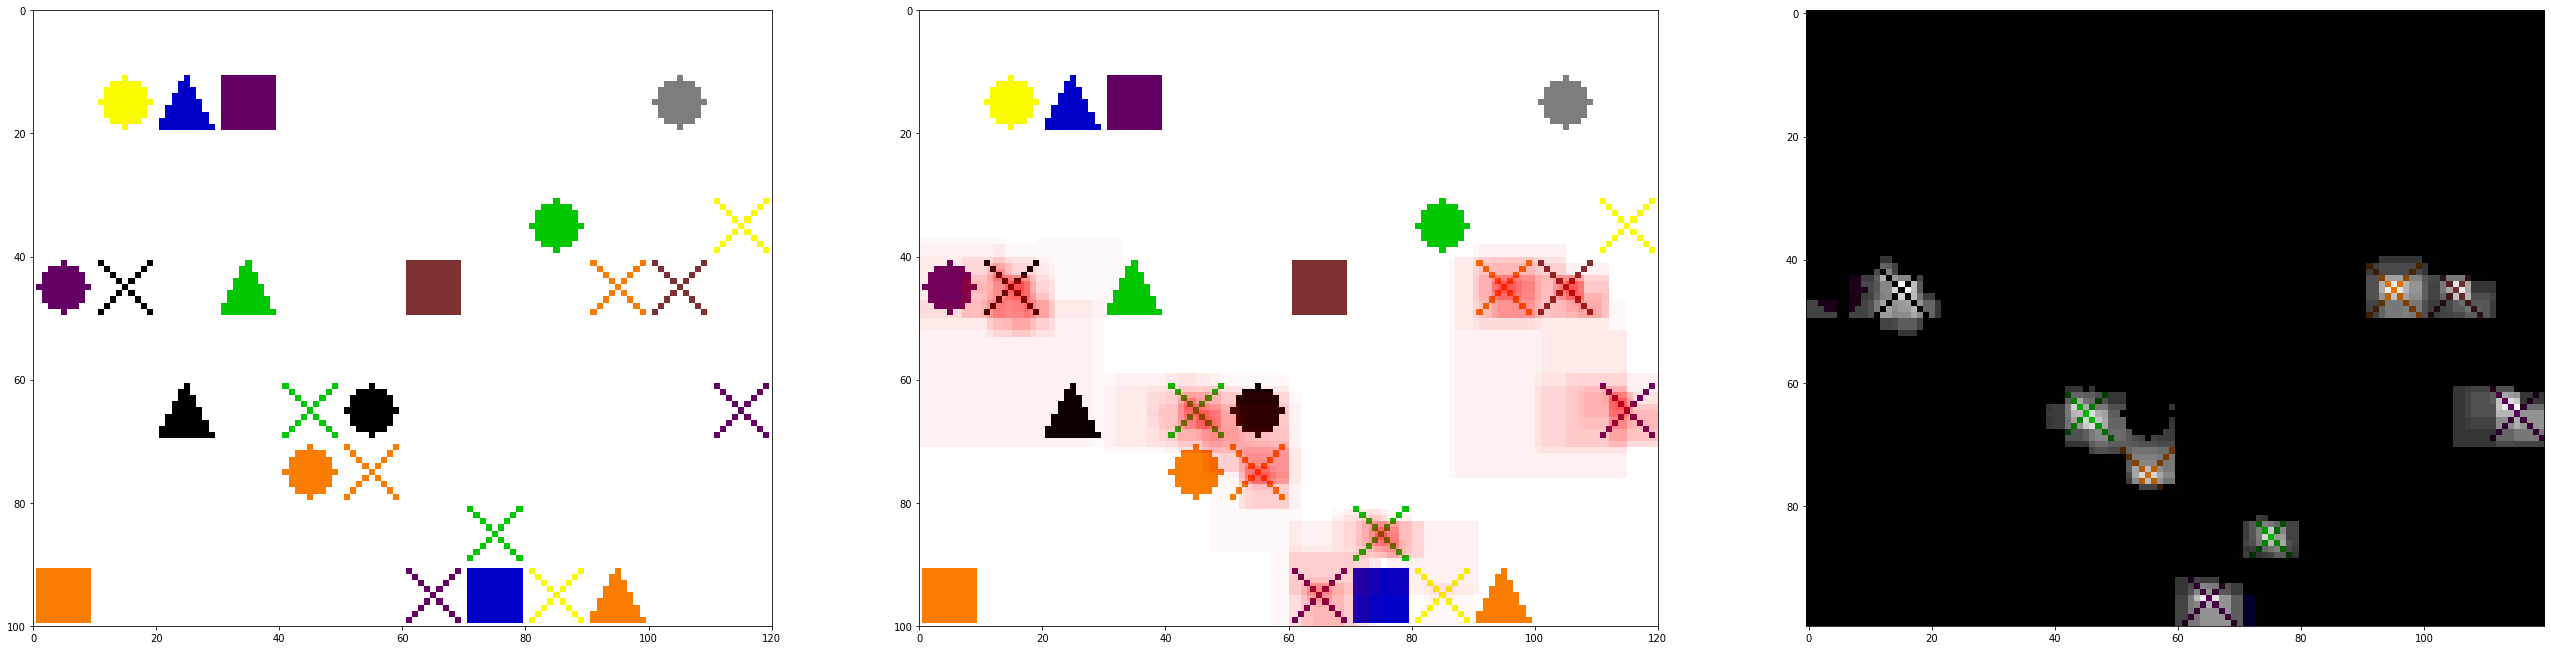

In [42]:
h.saliency_map(images[1], labels[1], tolerance = [2,3,4,5,6], only_one_run = False, max_depth = 30, debug = False)


# EXAMPLE 0

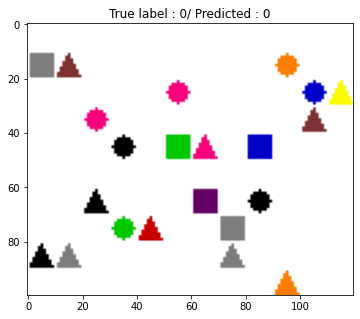

In [5]:
image0 = images[0]
label0 = labels[0]

input0 = image0.view(-1, 3, 100, 120) # This shape is necessary for the network 
output0 = net(input0)
_, predicted0 = torch.max(output0.data, 1)

img0 = utils.input2image(image0, MEAN, STD)
utils.display_image(img0, label0.numpy(), int(predicted0))

### Guided backpropagation explanation

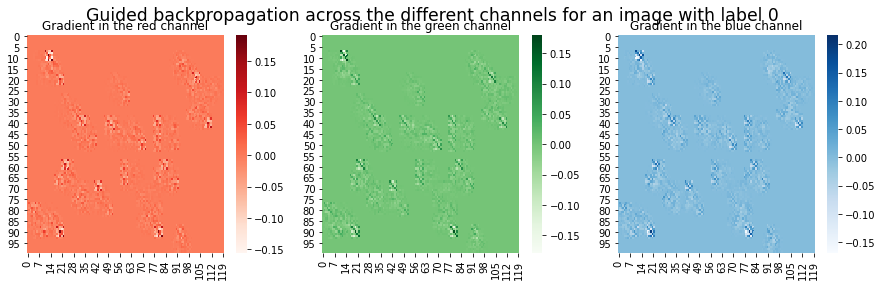

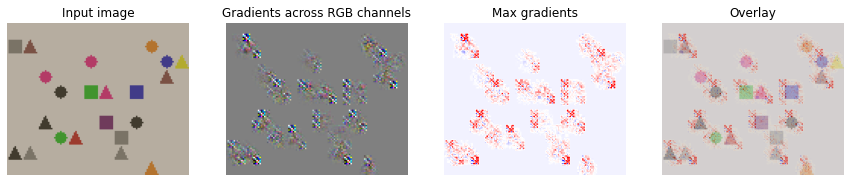

In [6]:
input0.requires_grad = True # Necessary to compute the gradient
gradients0 = backprop.calculate_gradients(input0, label0, guided = True).detach().numpy()
intp.display_gradients(gradients0, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input0, label0, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

### GradCAM explanation

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


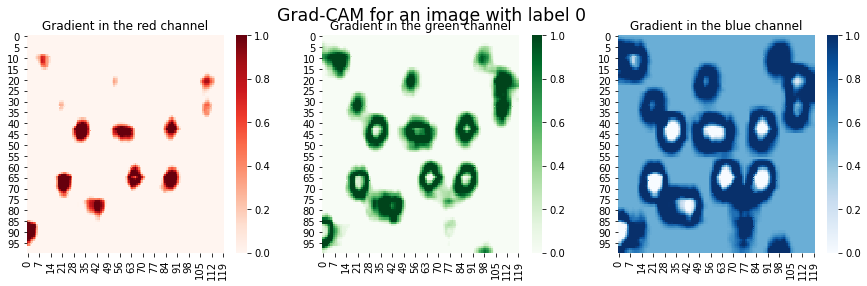

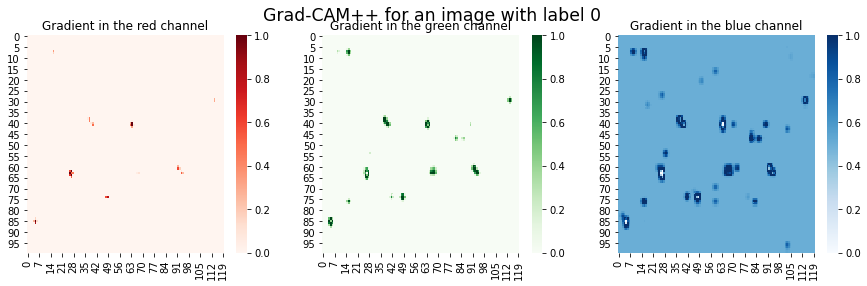

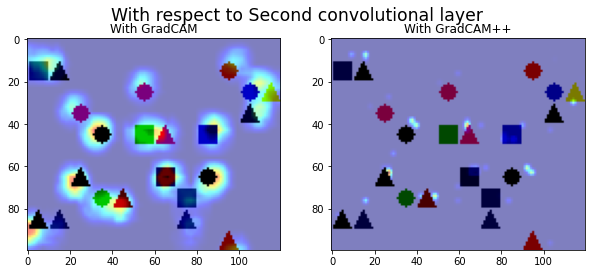

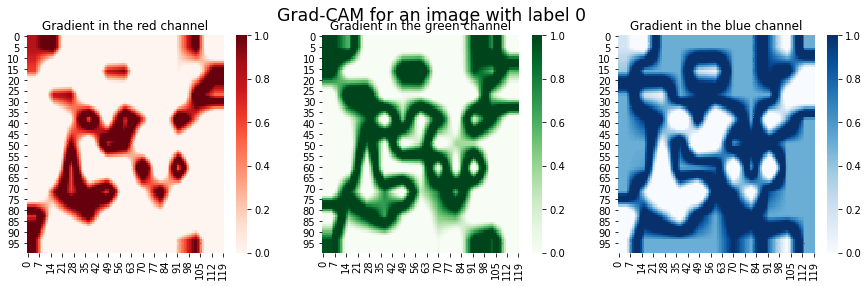

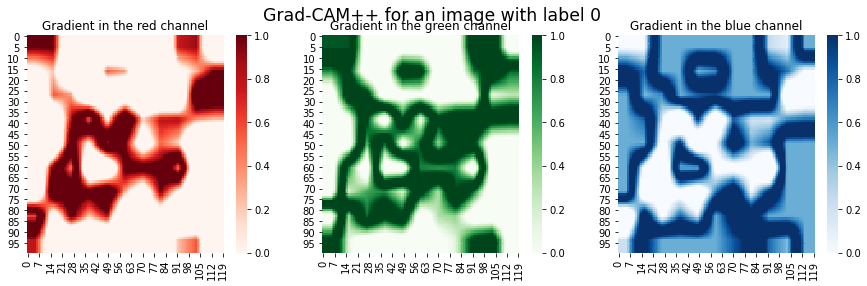

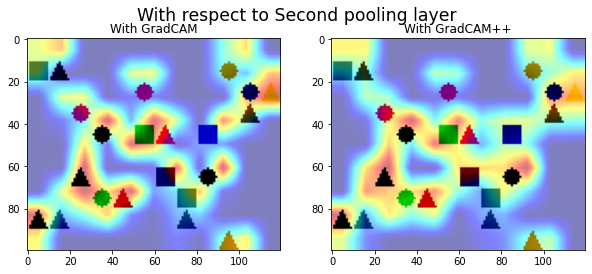

In [7]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input0, img0,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input0, img0,  "Second pooling layer", FIGSIZE)

### SmoothCAM explanation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 1.0
predicted class ids 0	 probability 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 0	 probability 1.0


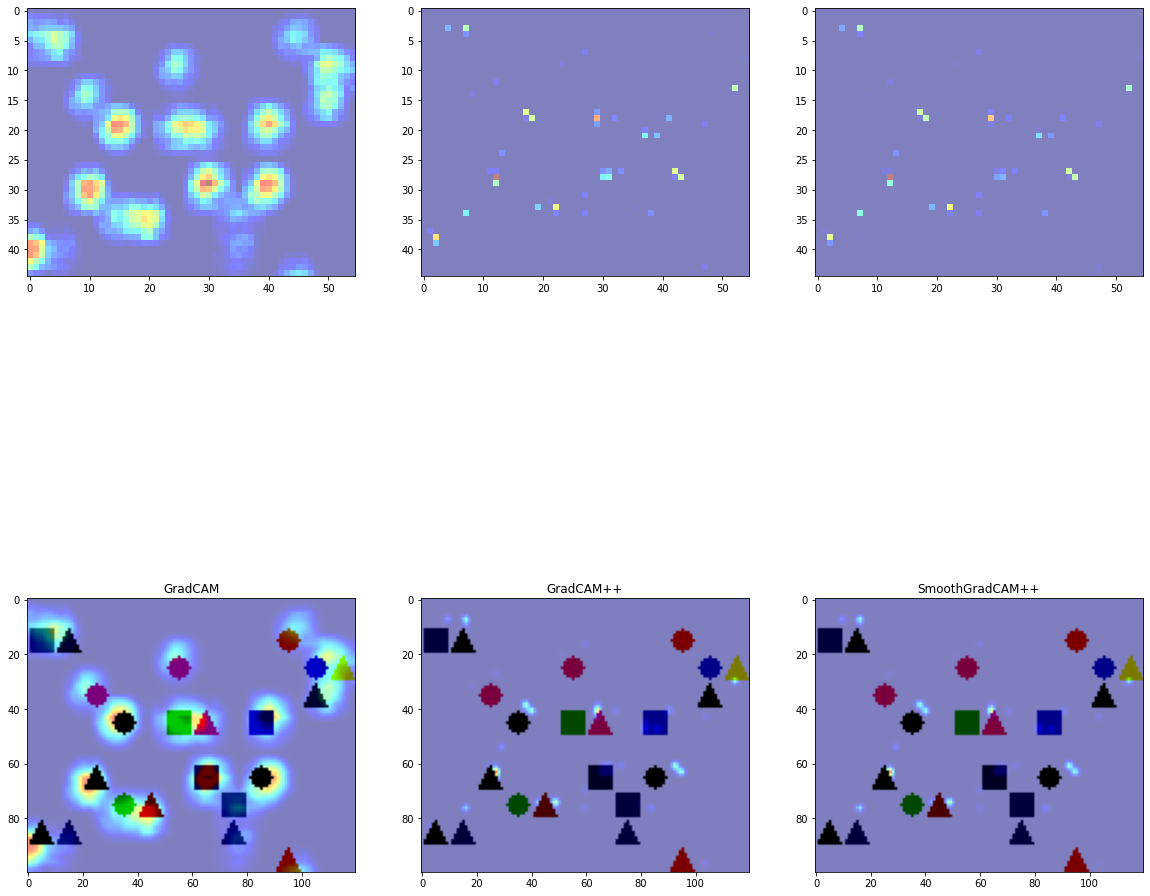

In [8]:
intp.smooth_exp(input0, image0, wrapped)

### Shapley explanation

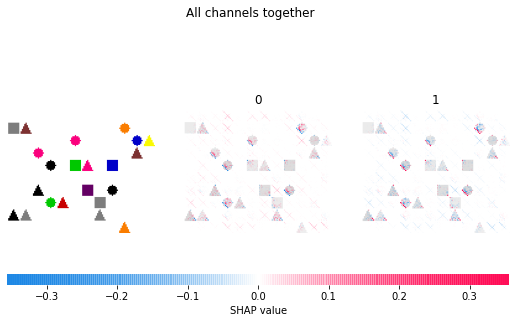

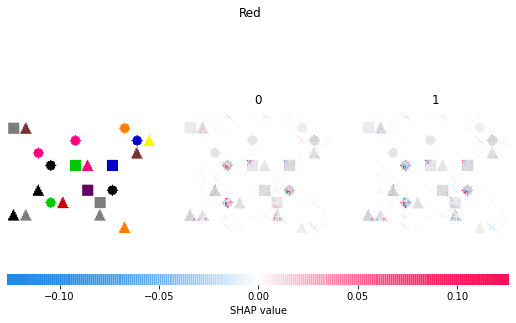

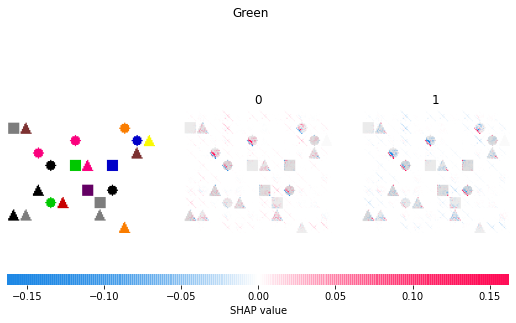

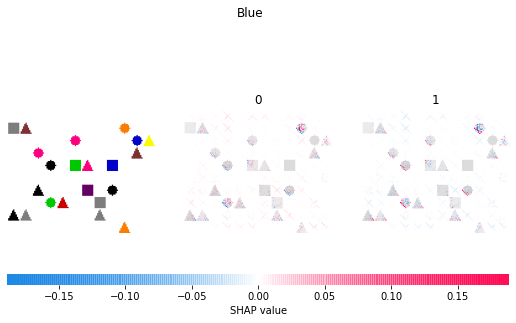

In [9]:
intp.shap_exp(e, input0.detach(), img0)

### Hierarchical Shapley explanation

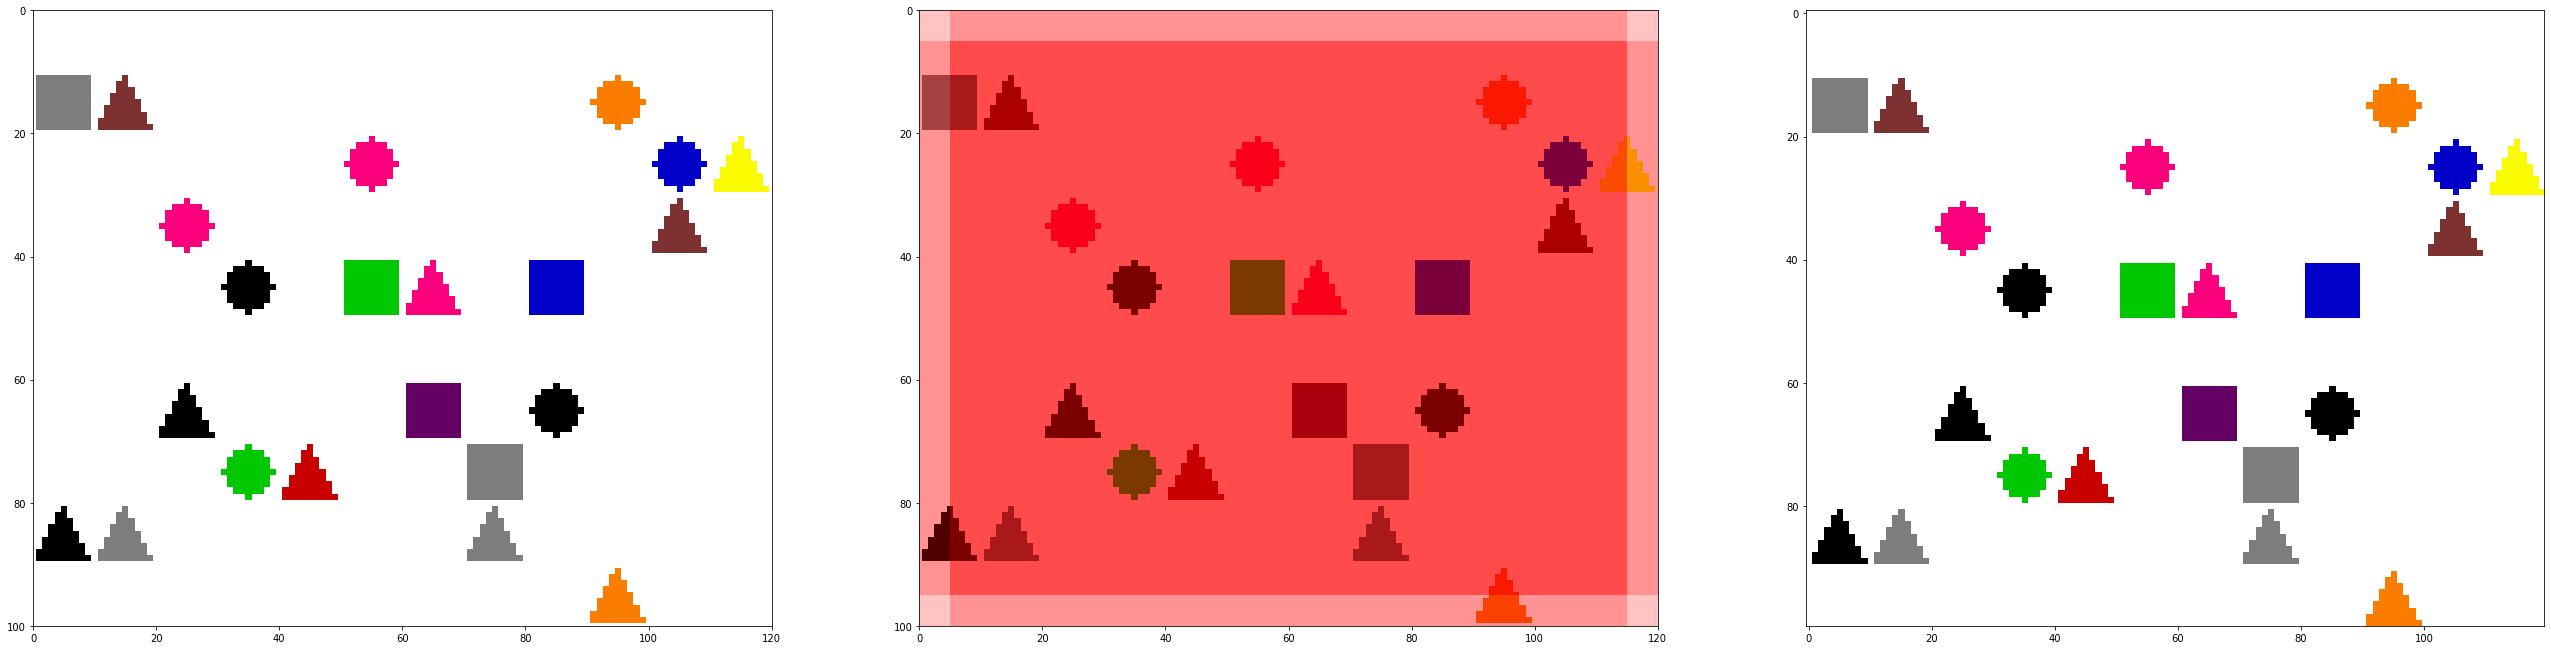

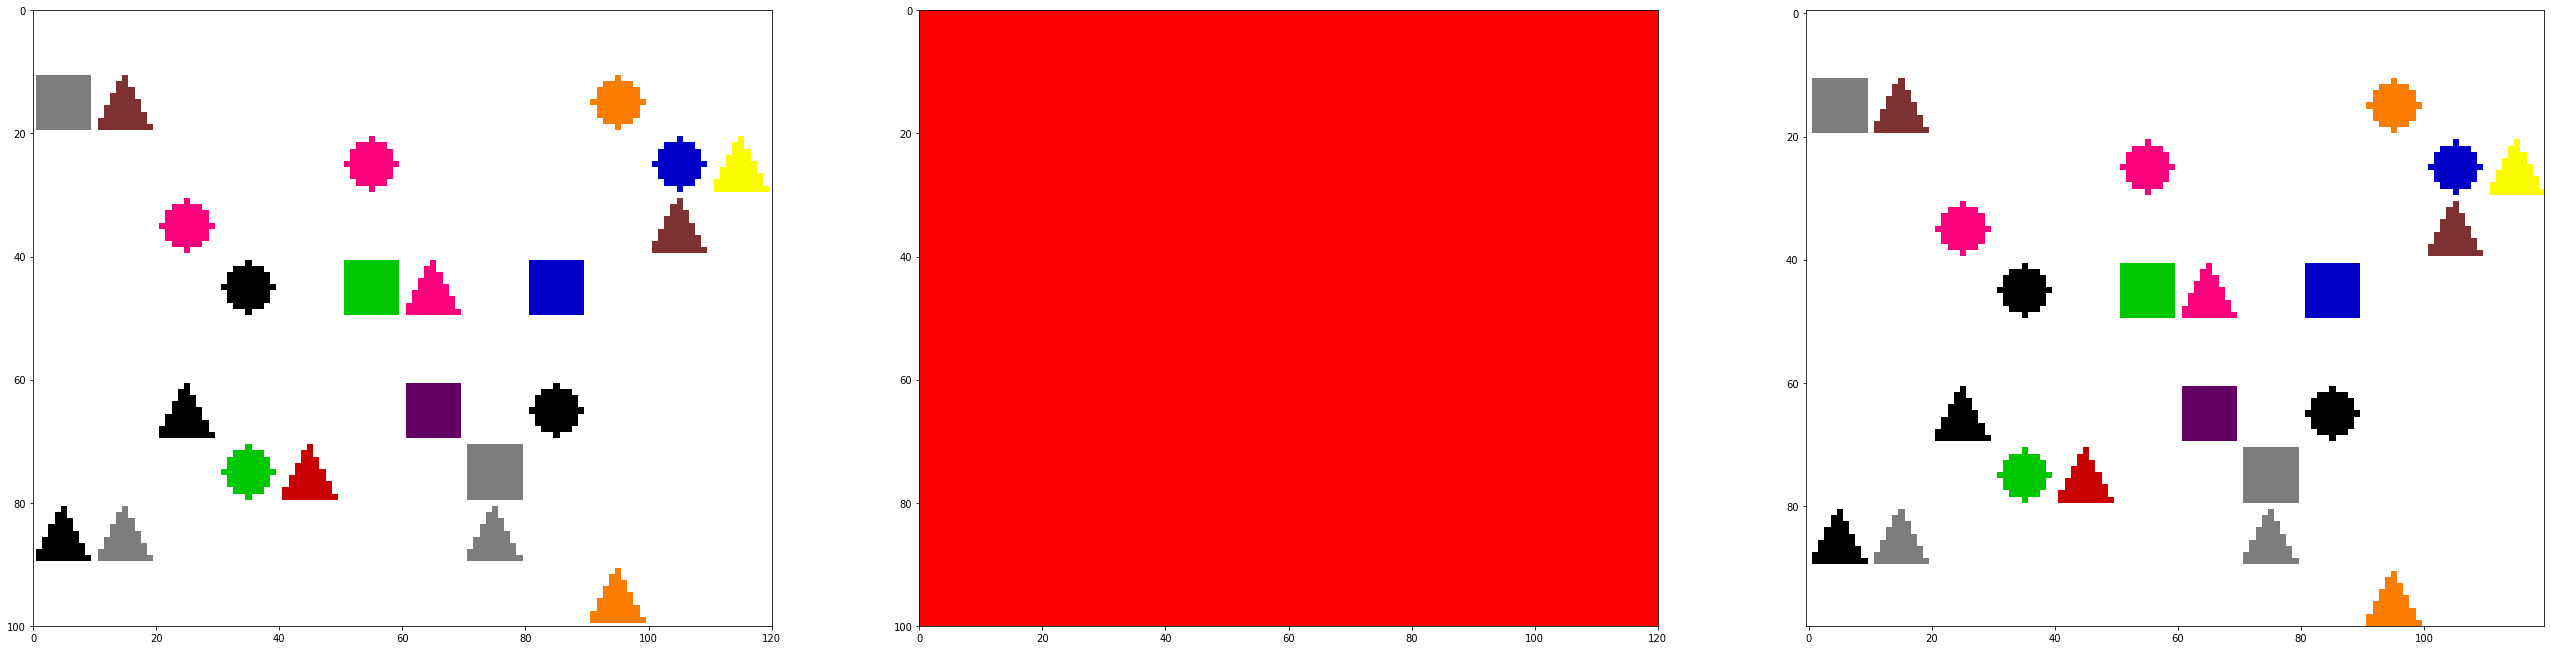

In [10]:
h.saliency_map(image0, label0, tolerance  = [5,5.5,6,6.5,7])
h.saliency_map(image0, label0, tolerance = [6], only_one_run = True)


# EXAMPLE 1

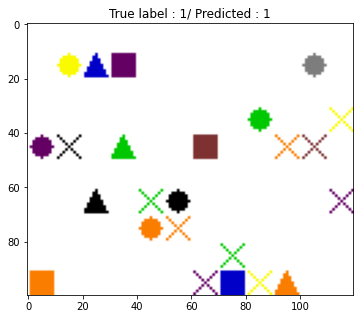

In [11]:
image1 = images[1]
label1 = labels[1]

input1 = image1.view(-1, 3, 100, 120)
output1 = net(input1)
_, predicted1 = torch.max(output1.data, 1)

img1 = utils.input2image(image1, MEAN, STD)
utils.display_image(img1, label1.numpy(), int(predicted1))

### Backpropagation

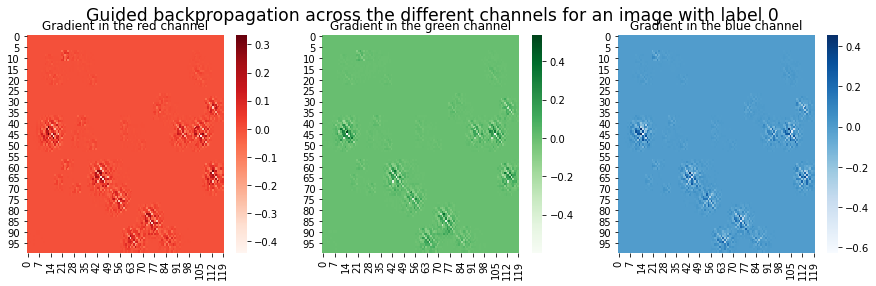

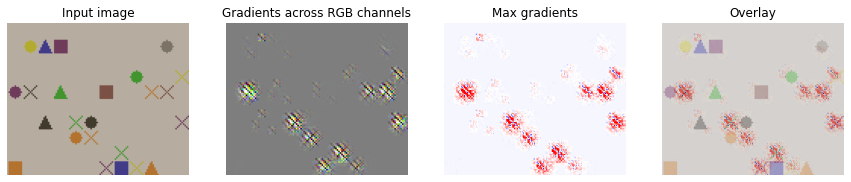

In [12]:
input1.requires_grad = True # Necessary to compute the gradient
gradients1 = backprop.calculate_gradients(input1, label1, guided = True).detach().numpy()
intp.display_gradients(gradients1, FIGSIZE).suptitle("Guided backpropagation across the different channels for an image with label 0", size="xx-large");
backprop.visualize(input1, label1, guided=True, figsize = (3*FIGSIZE[0], FIGSIZE[1]), cmap="bwr")

### GradCAM

nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


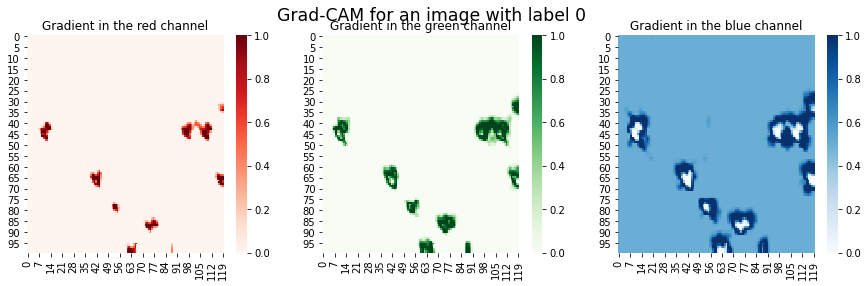

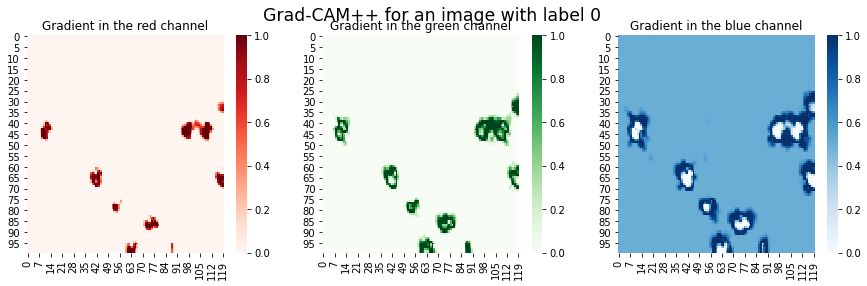

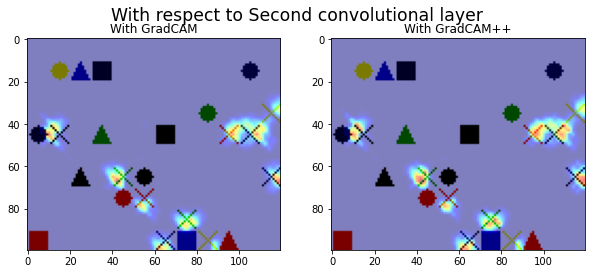

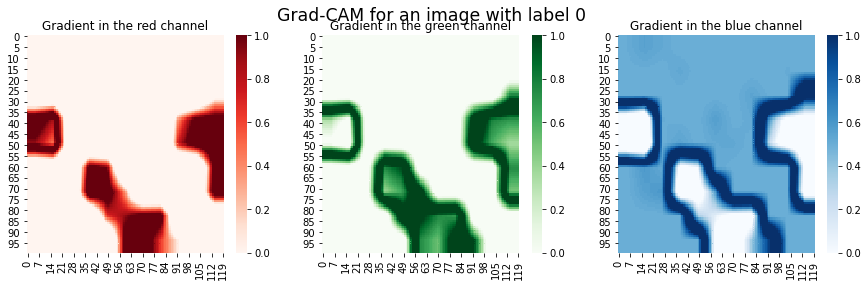

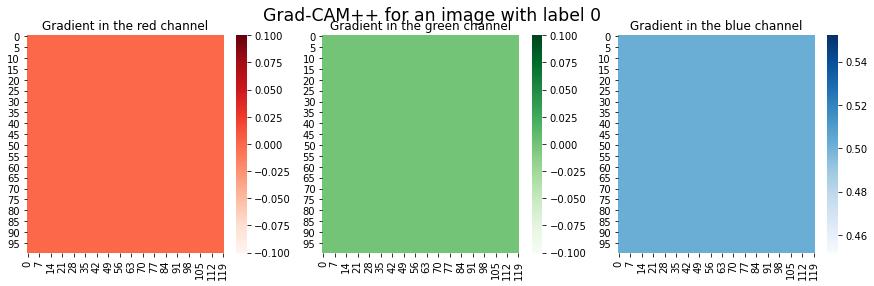

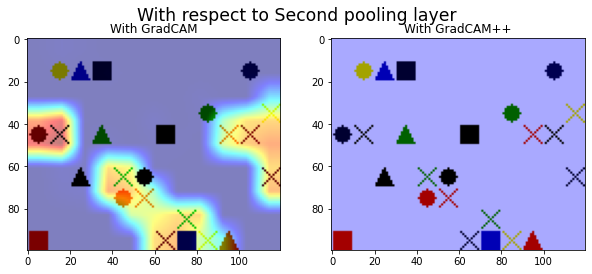

In [13]:
intp.gradcam_exp(gradcam_conv, gradcam_pp_conv, input1, img1,  "Second convolutional layer", FIGSIZE)
intp.gradcam_exp(gradcam_pool, gradcam_pp_pool, input1, img1,  "Second pooling layer", FIGSIZE)

### SmoothCAM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 1.0
predicted class ids 1	 probability 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


predicted class ids 1	 probability 1.0


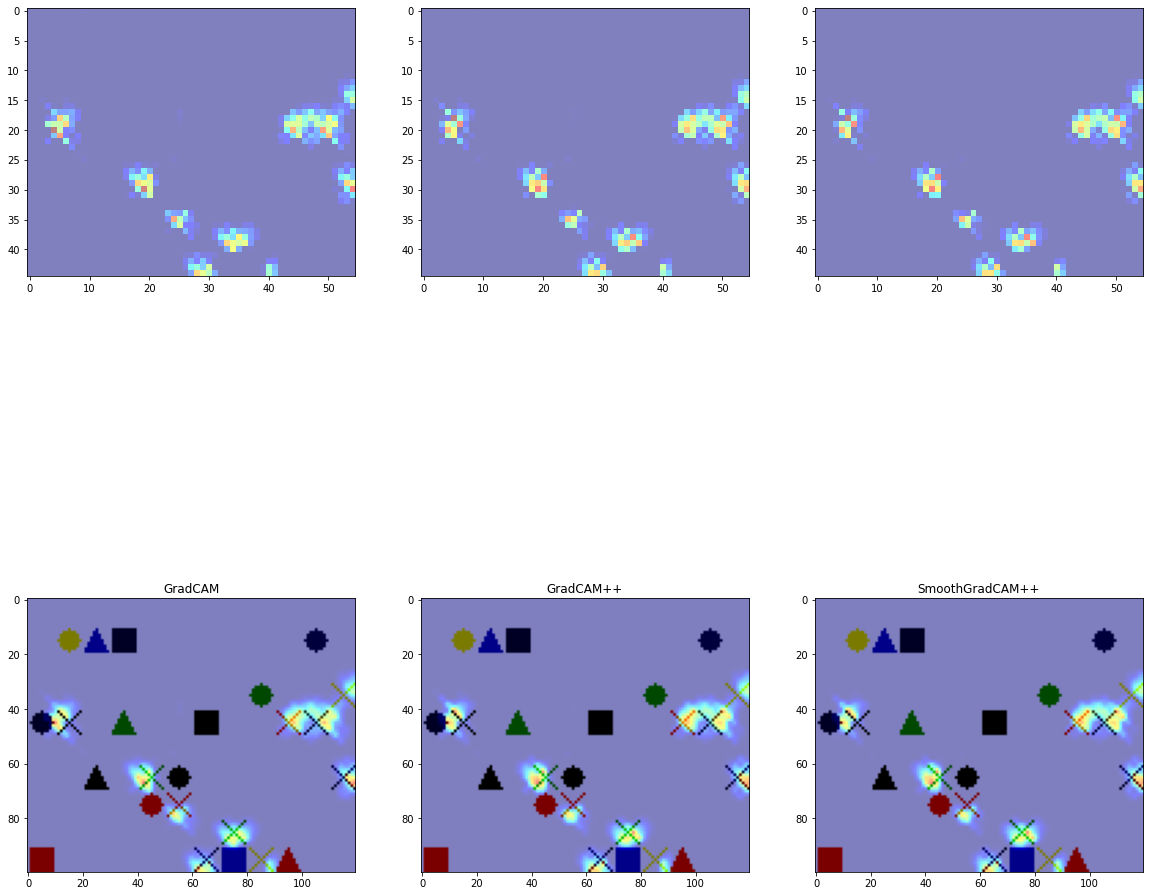

In [14]:
intp.smooth_exp(input1, image1, wrapped)

### Shapley explanation

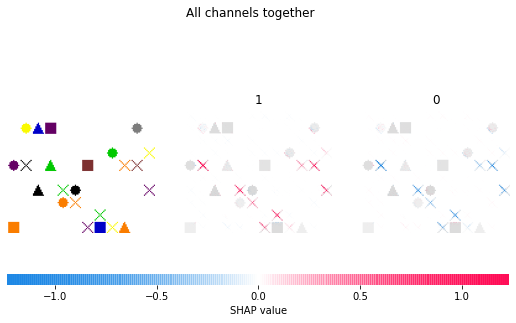

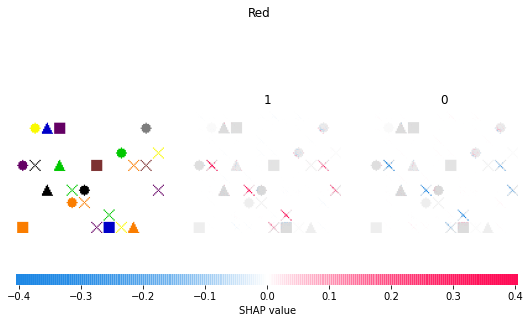

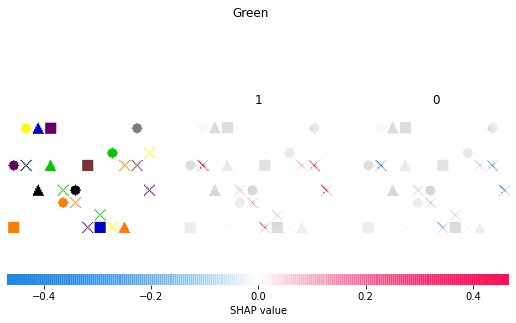

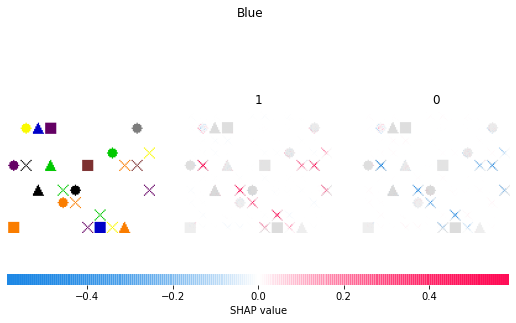

In [15]:
intp.shap_exp(e, input1.detach(), img1)

### Hierarchical Shapley

Depth 31 reached at tolerance 4.200000 Run ignored, consider increasing tolerance.


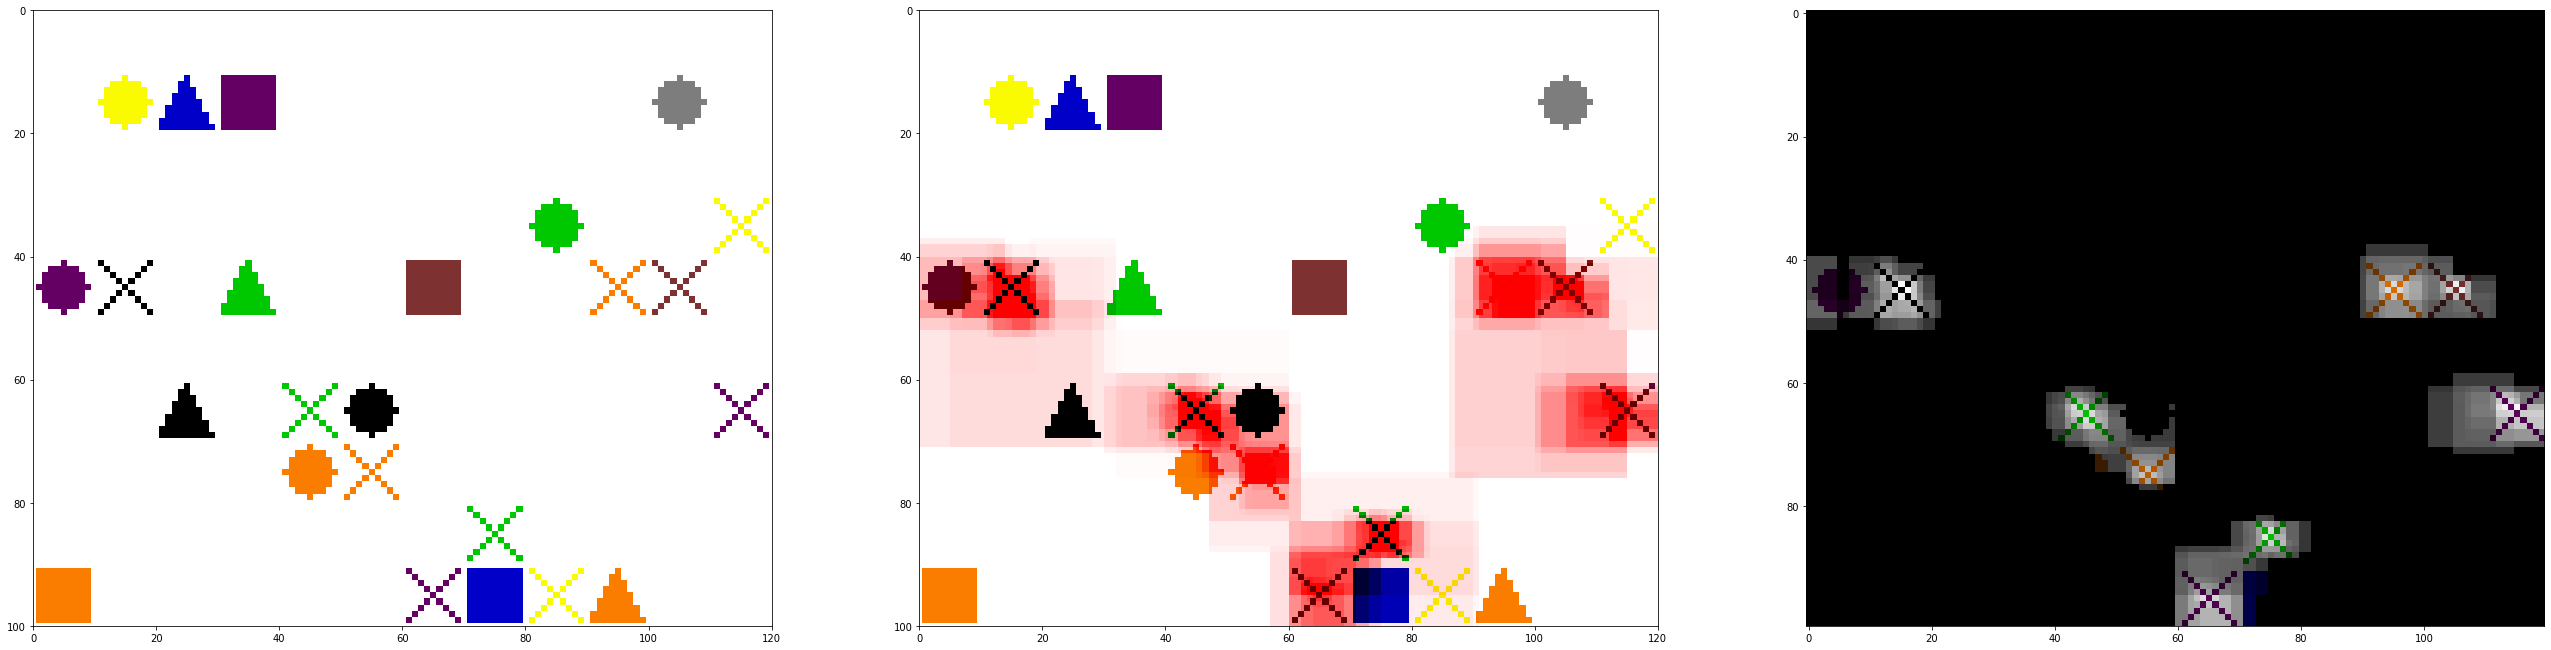

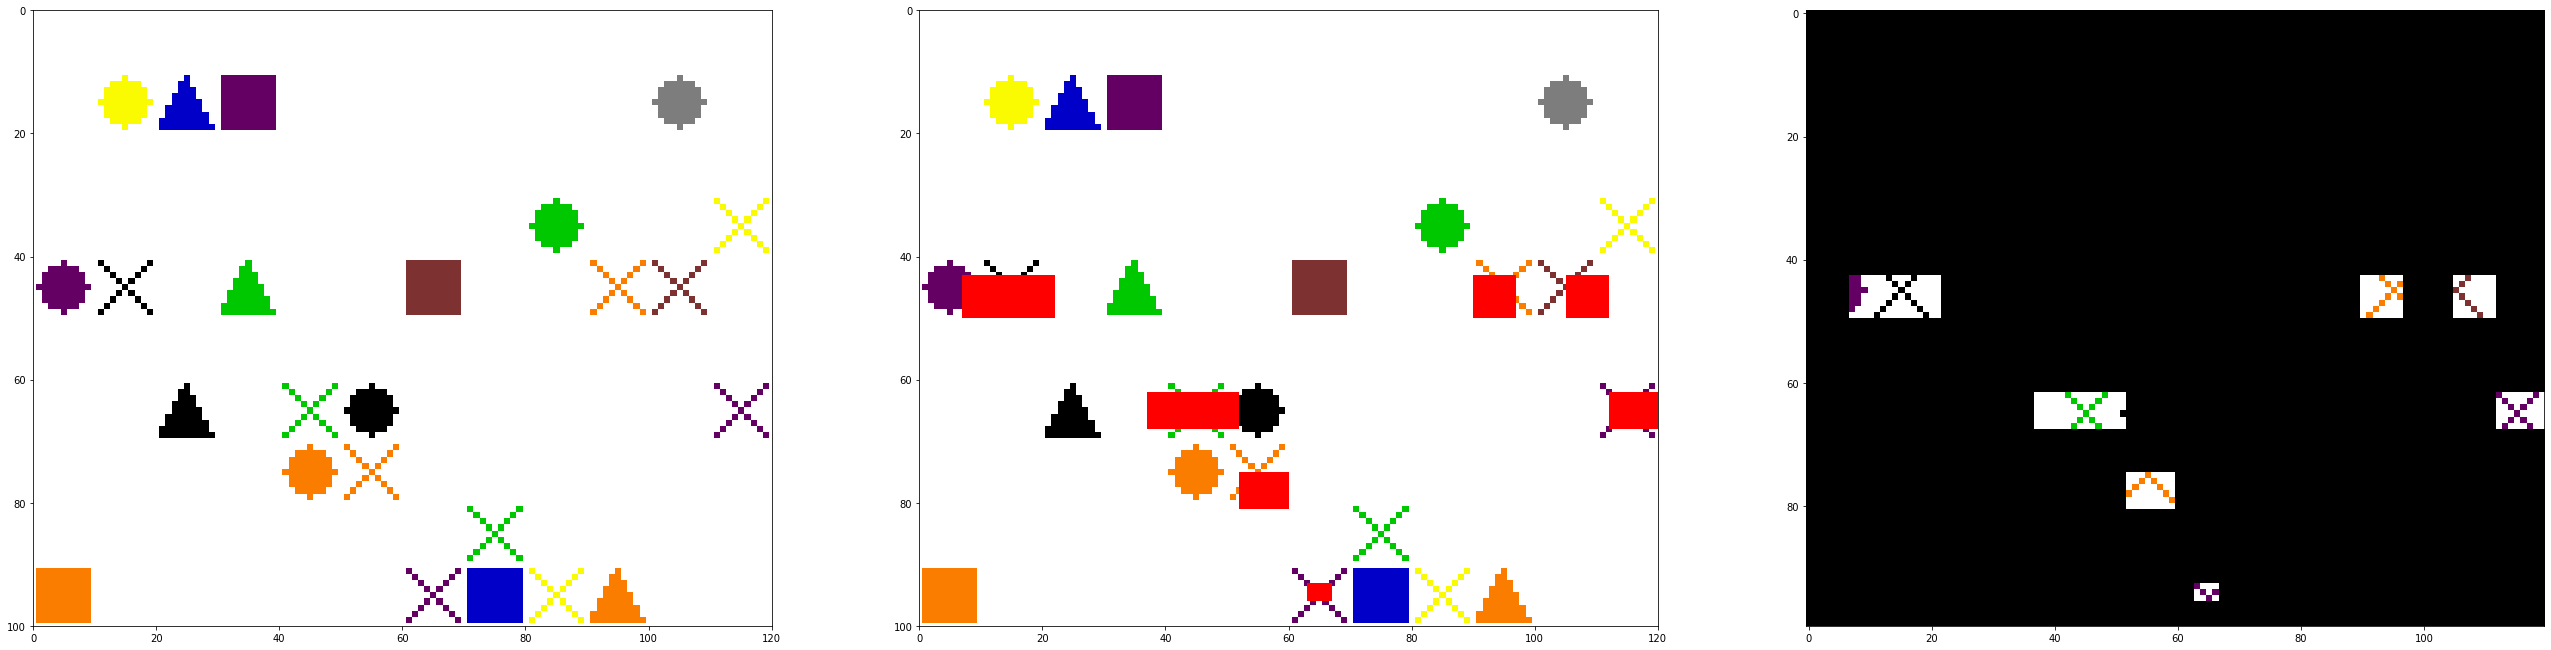

In [16]:

a = 6.0
f = np.linspace(0.7, 1.3, 30)
l = (f*a).tolist()
h.saliency_map(image1, label1, tolerance = l)
h.saliency_map(image1, label1, tolerance = [6], only_one_run = True)

In [0]:
train_data = ImageFolder(root = os.path.join(root_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = Batch_Size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)

images, labels = next(train_loader)
i = 0

Depth 31 reached at tolerance 4.200000 Run ignored, consider increasing tolerance.
Depth 31 reached at tolerance 4.324138 Run ignored, consider increasing tolerance.
Depth 31 reached at tolerance 4.448276 Run ignored, consider increasing tolerance.
Depth 31 reached at tolerance 4.572414 Run ignored, consider increasing tolerance.
Depth 31 reached at tolerance 4.696552 Run ignored, consider increasing tolerance.


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


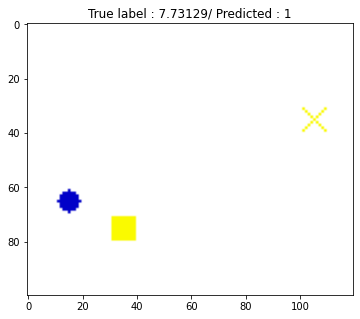

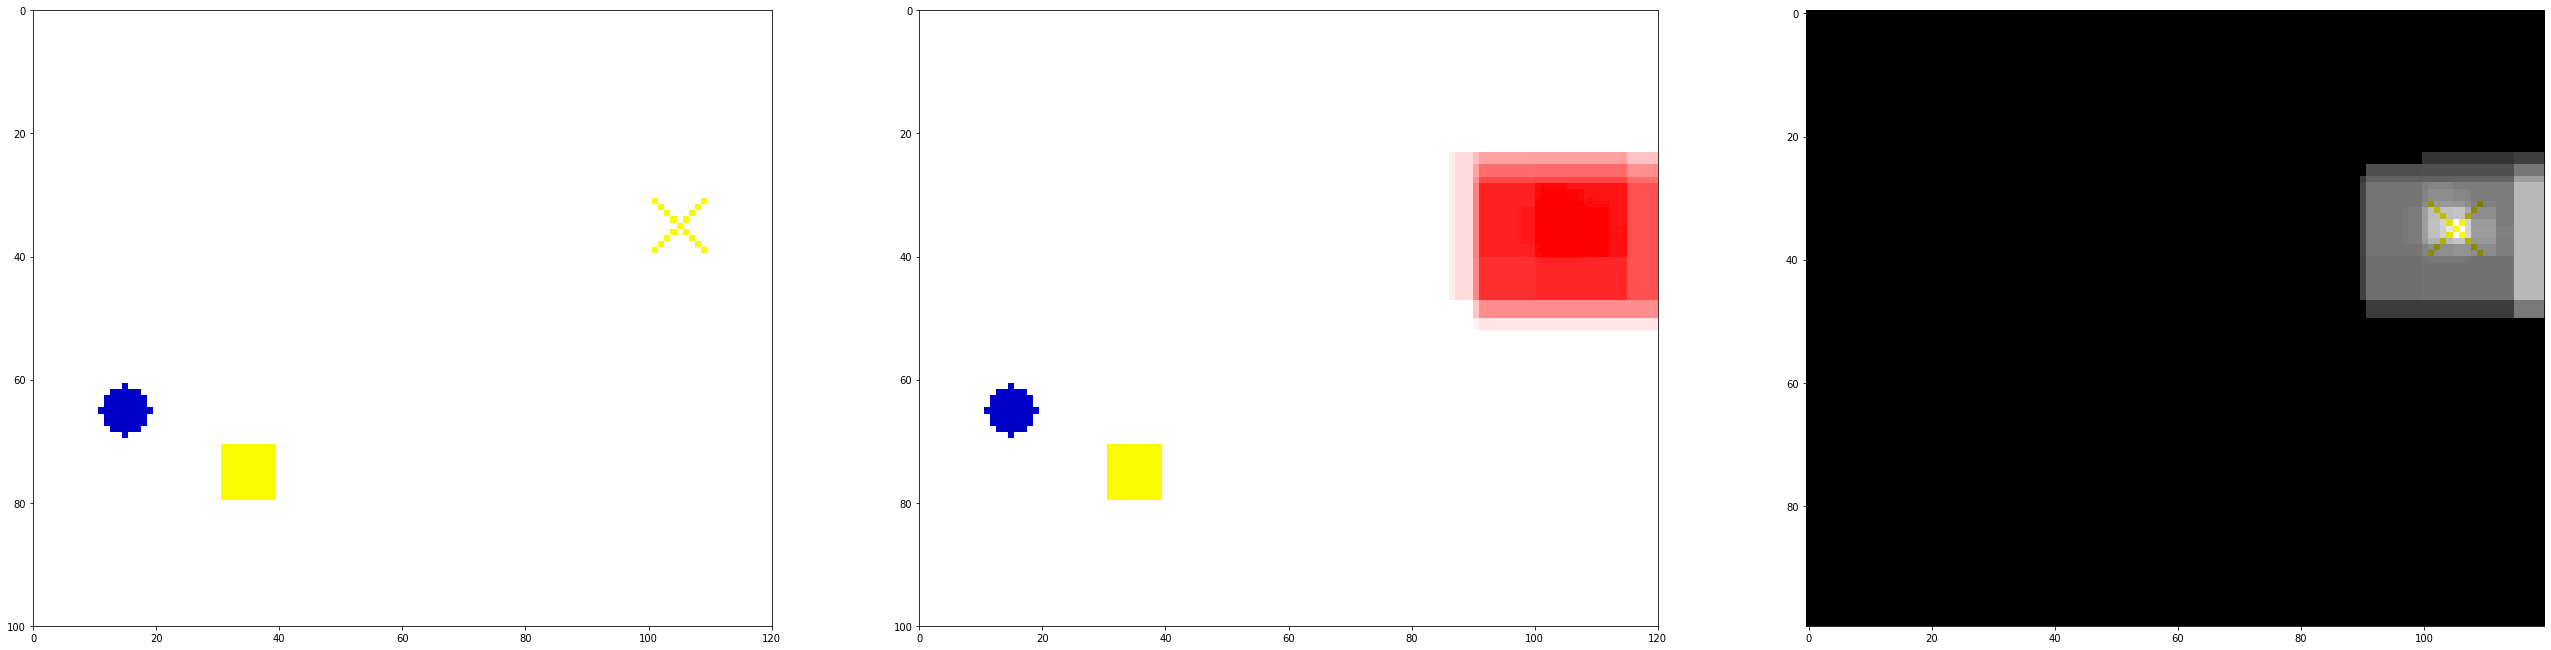

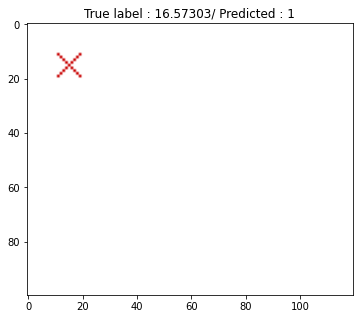

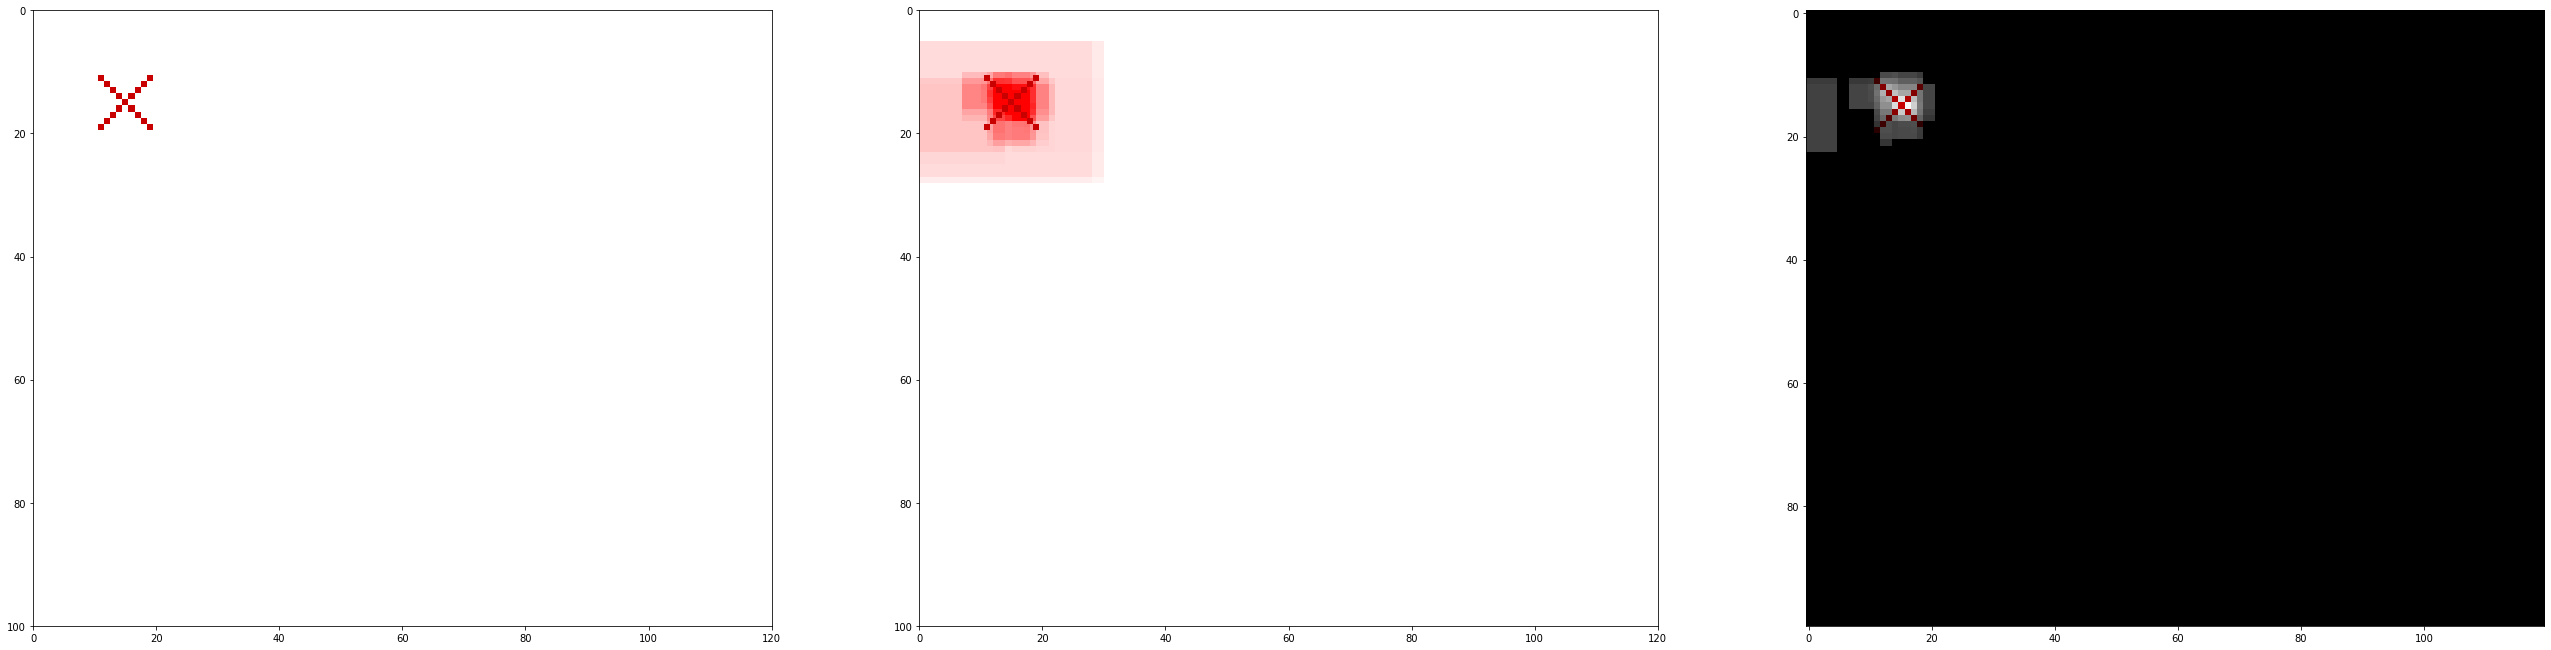

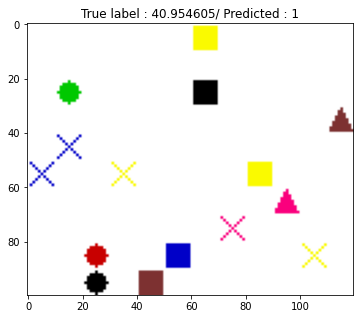

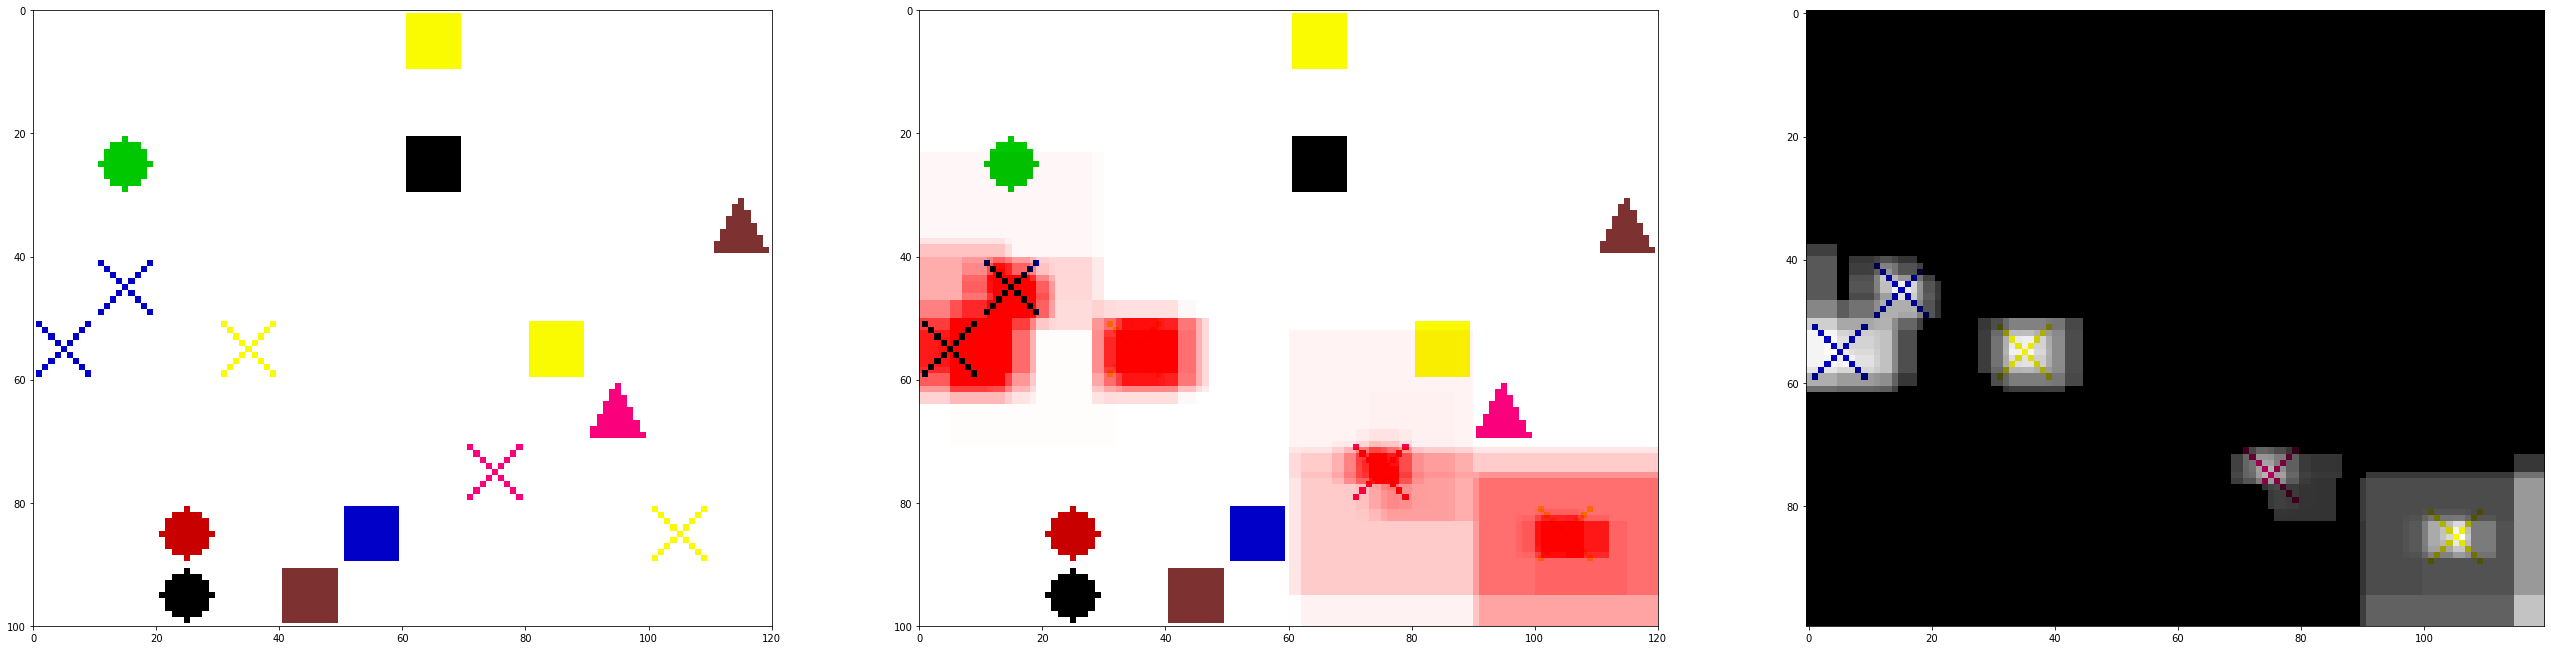

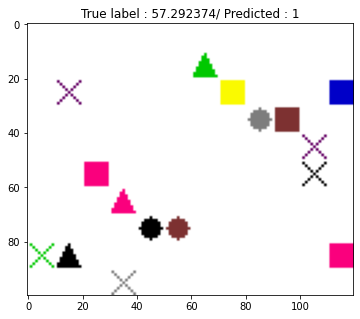

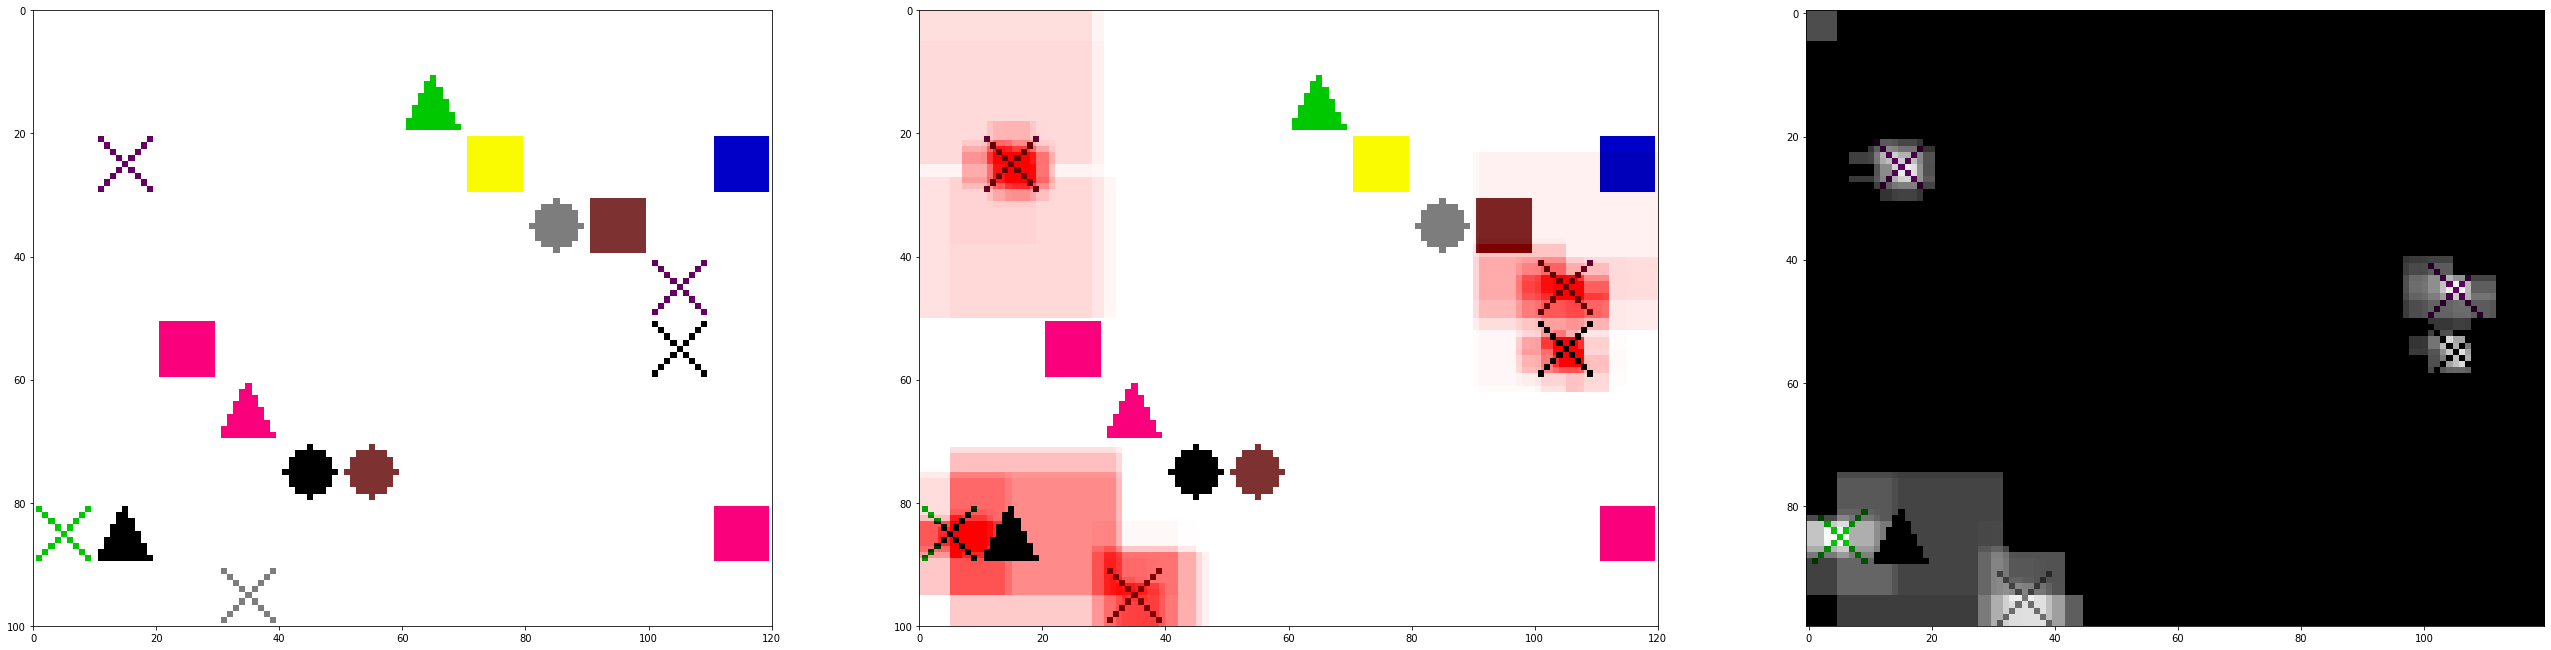

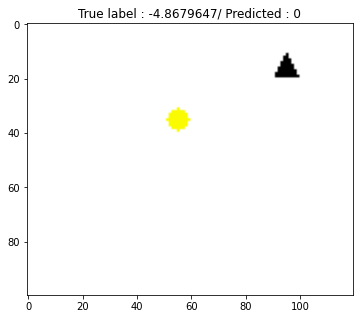

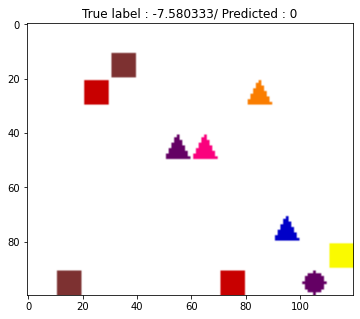

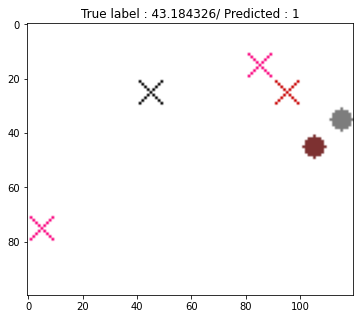

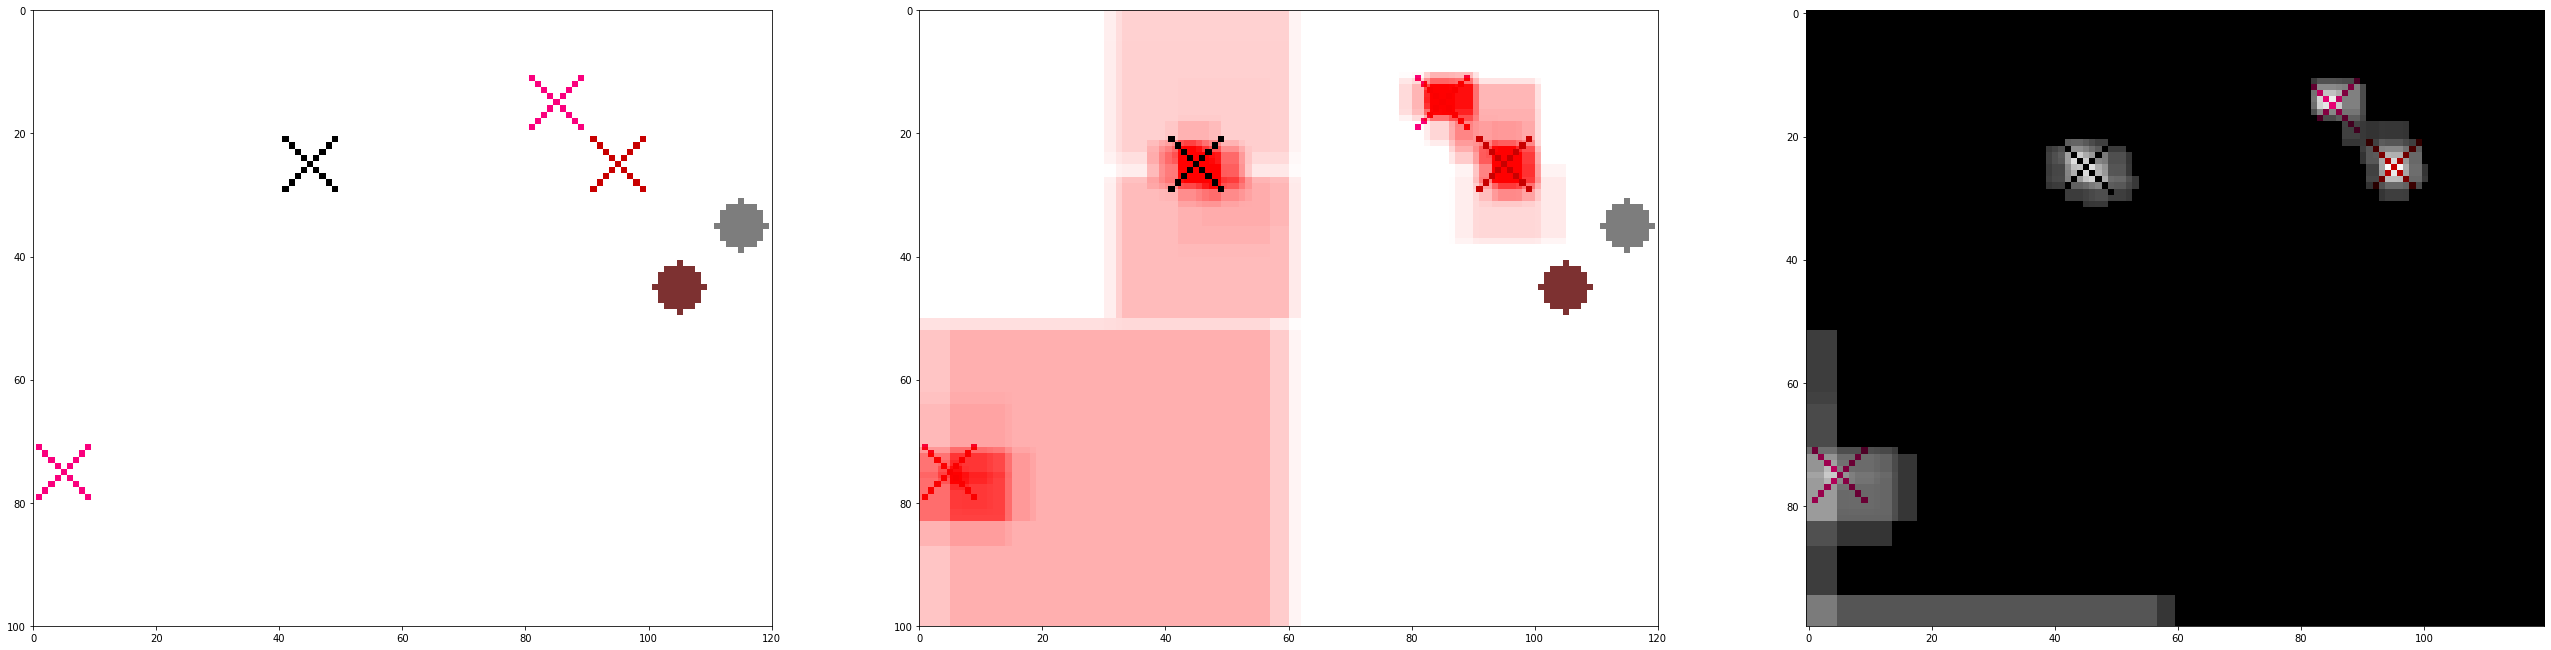

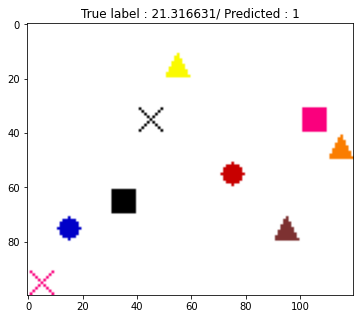

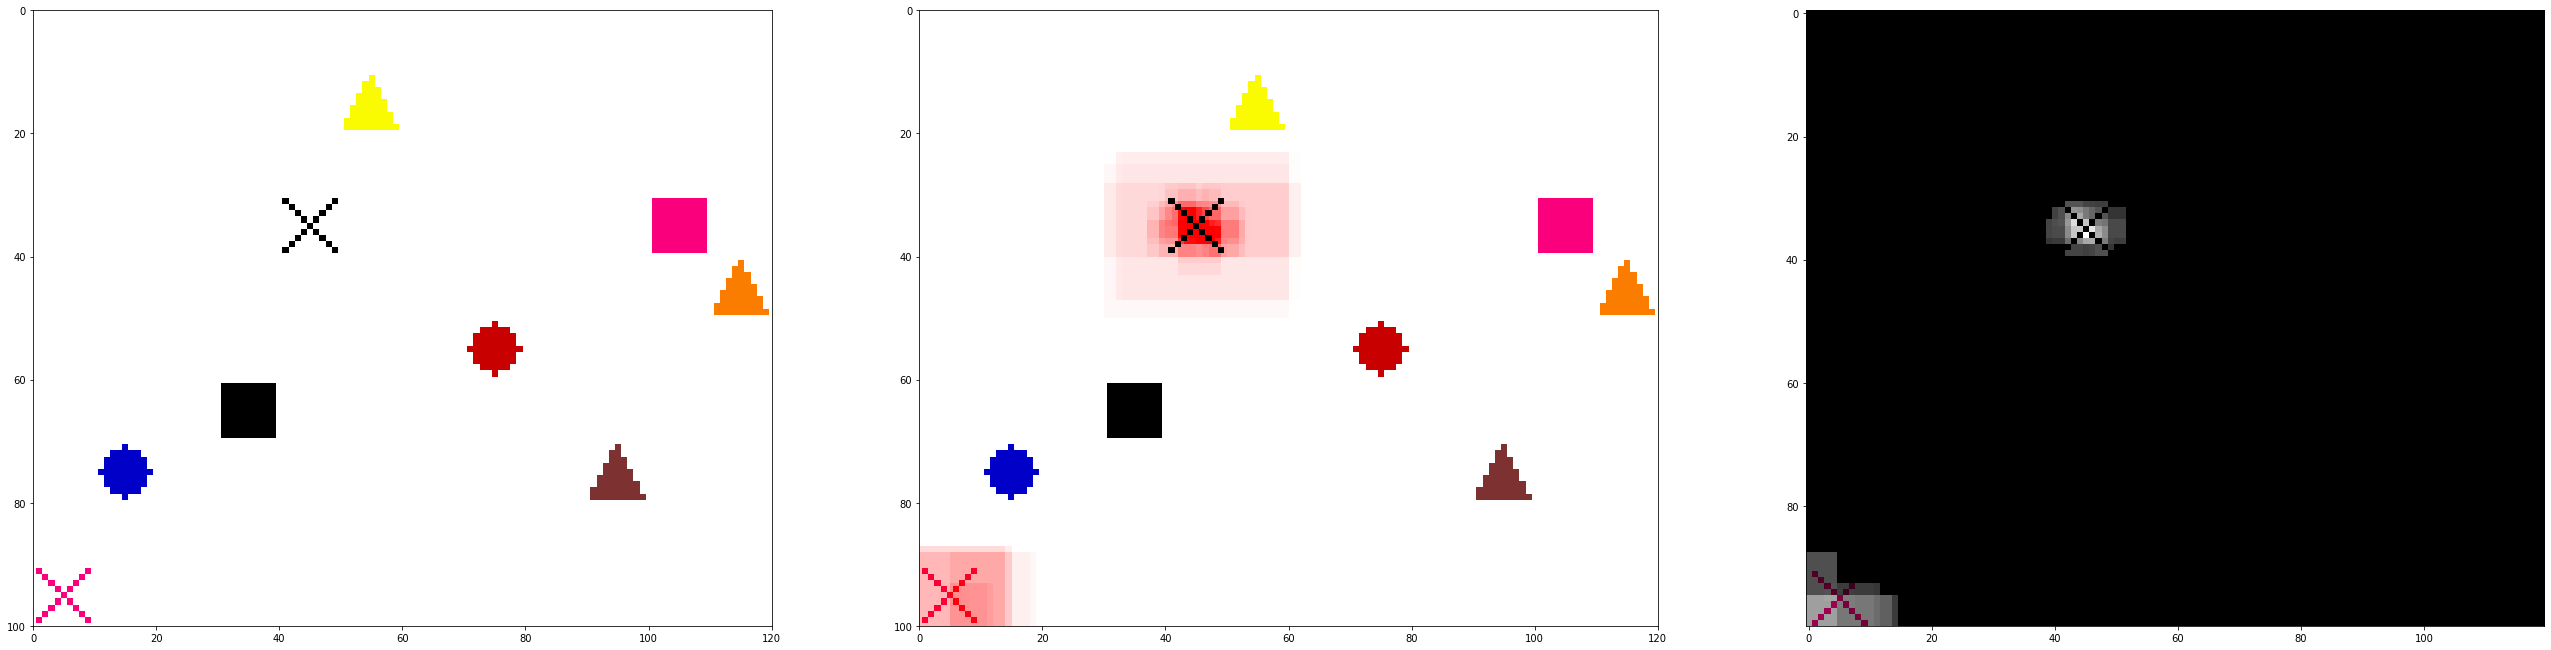

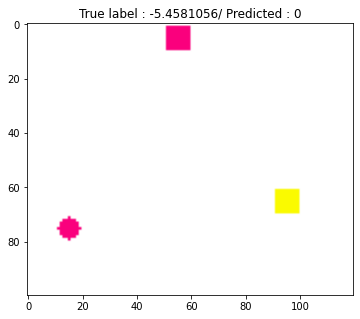

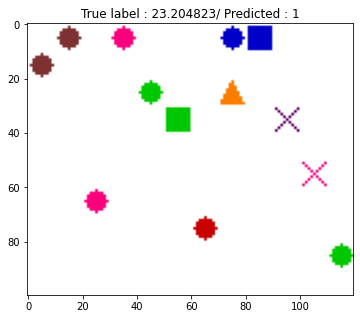

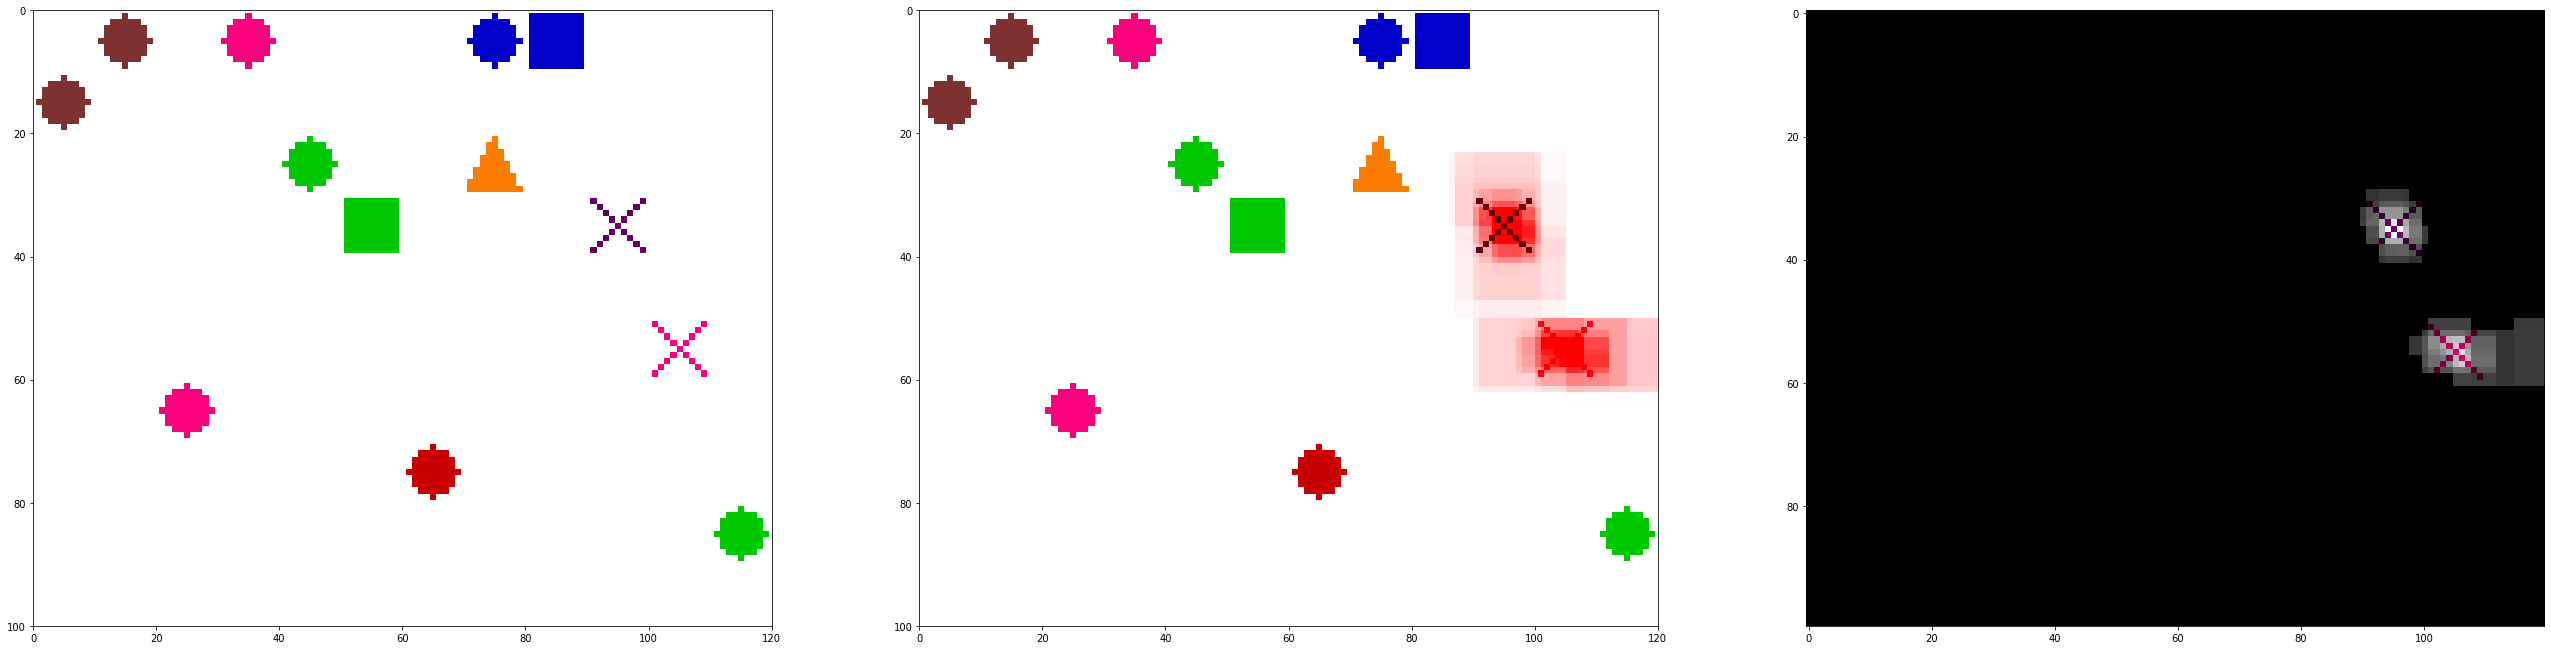

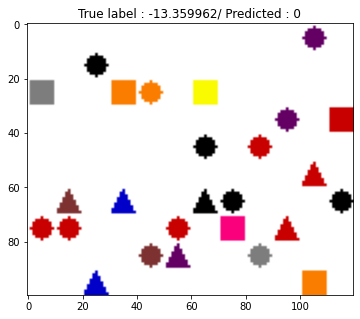

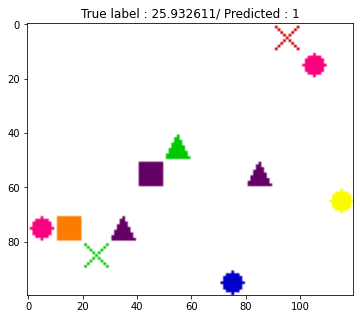

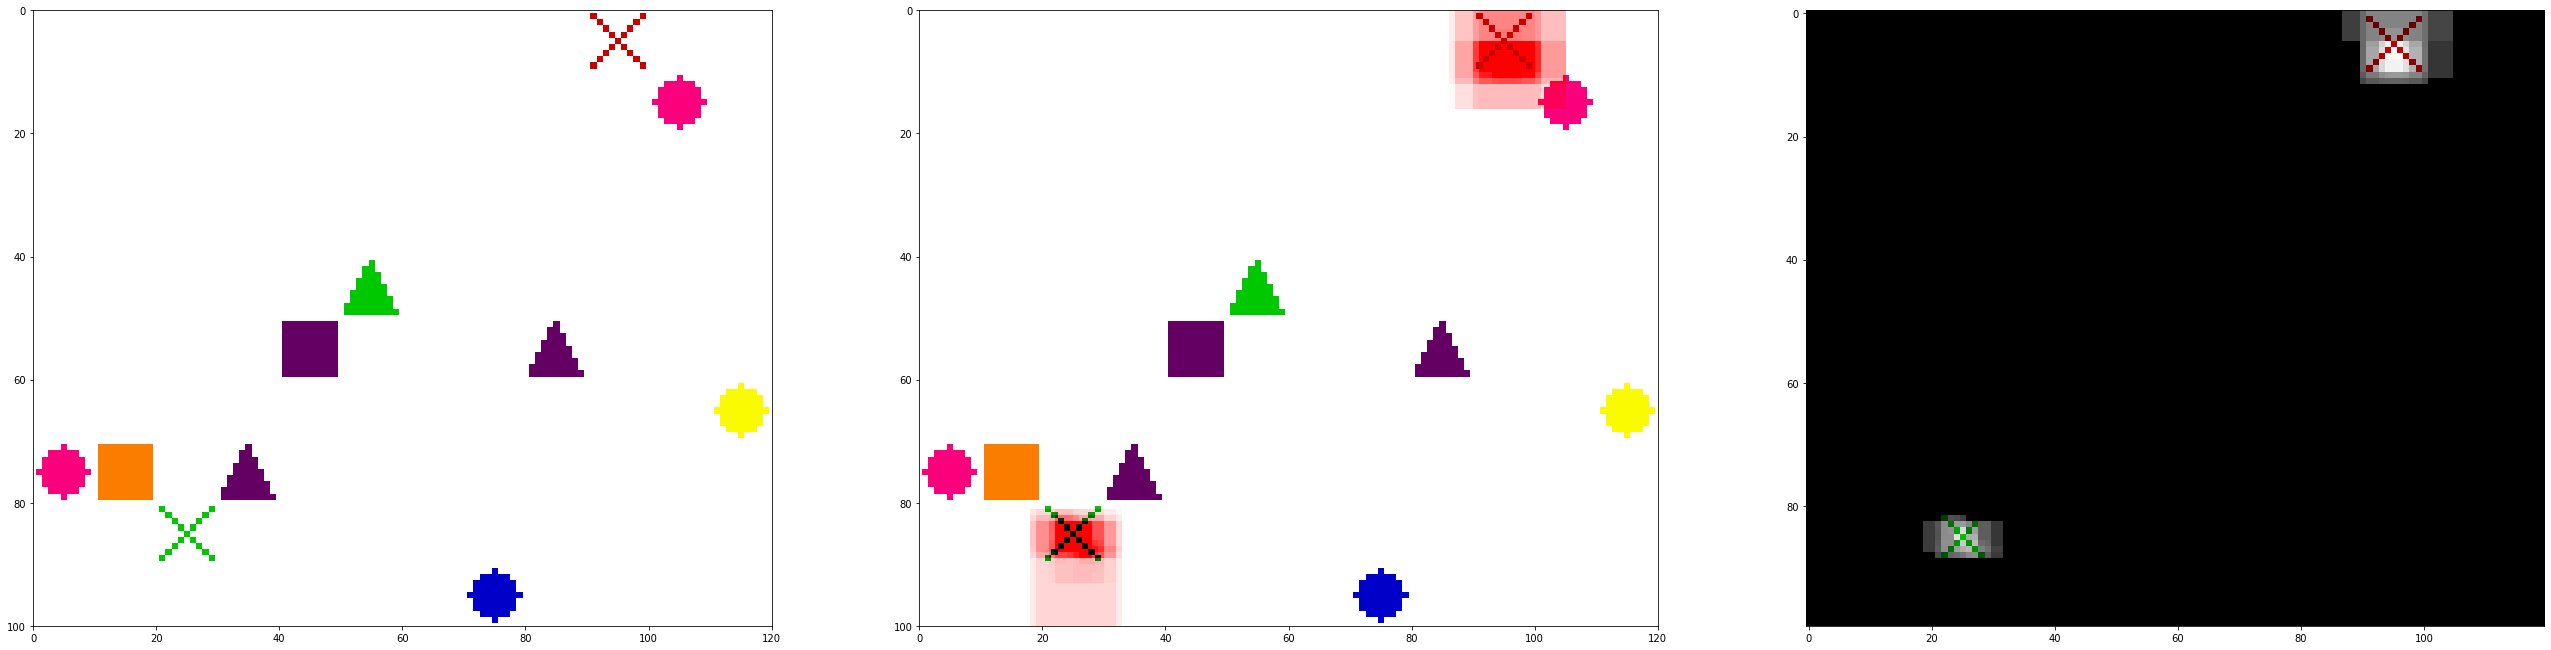

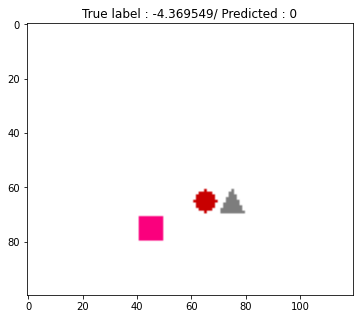

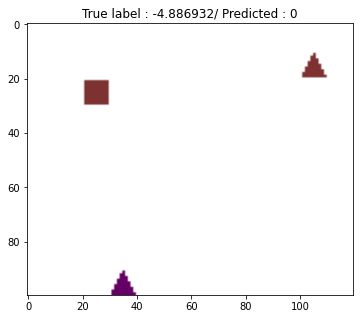

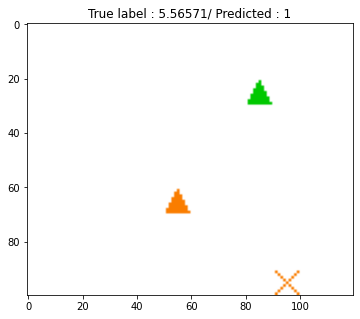

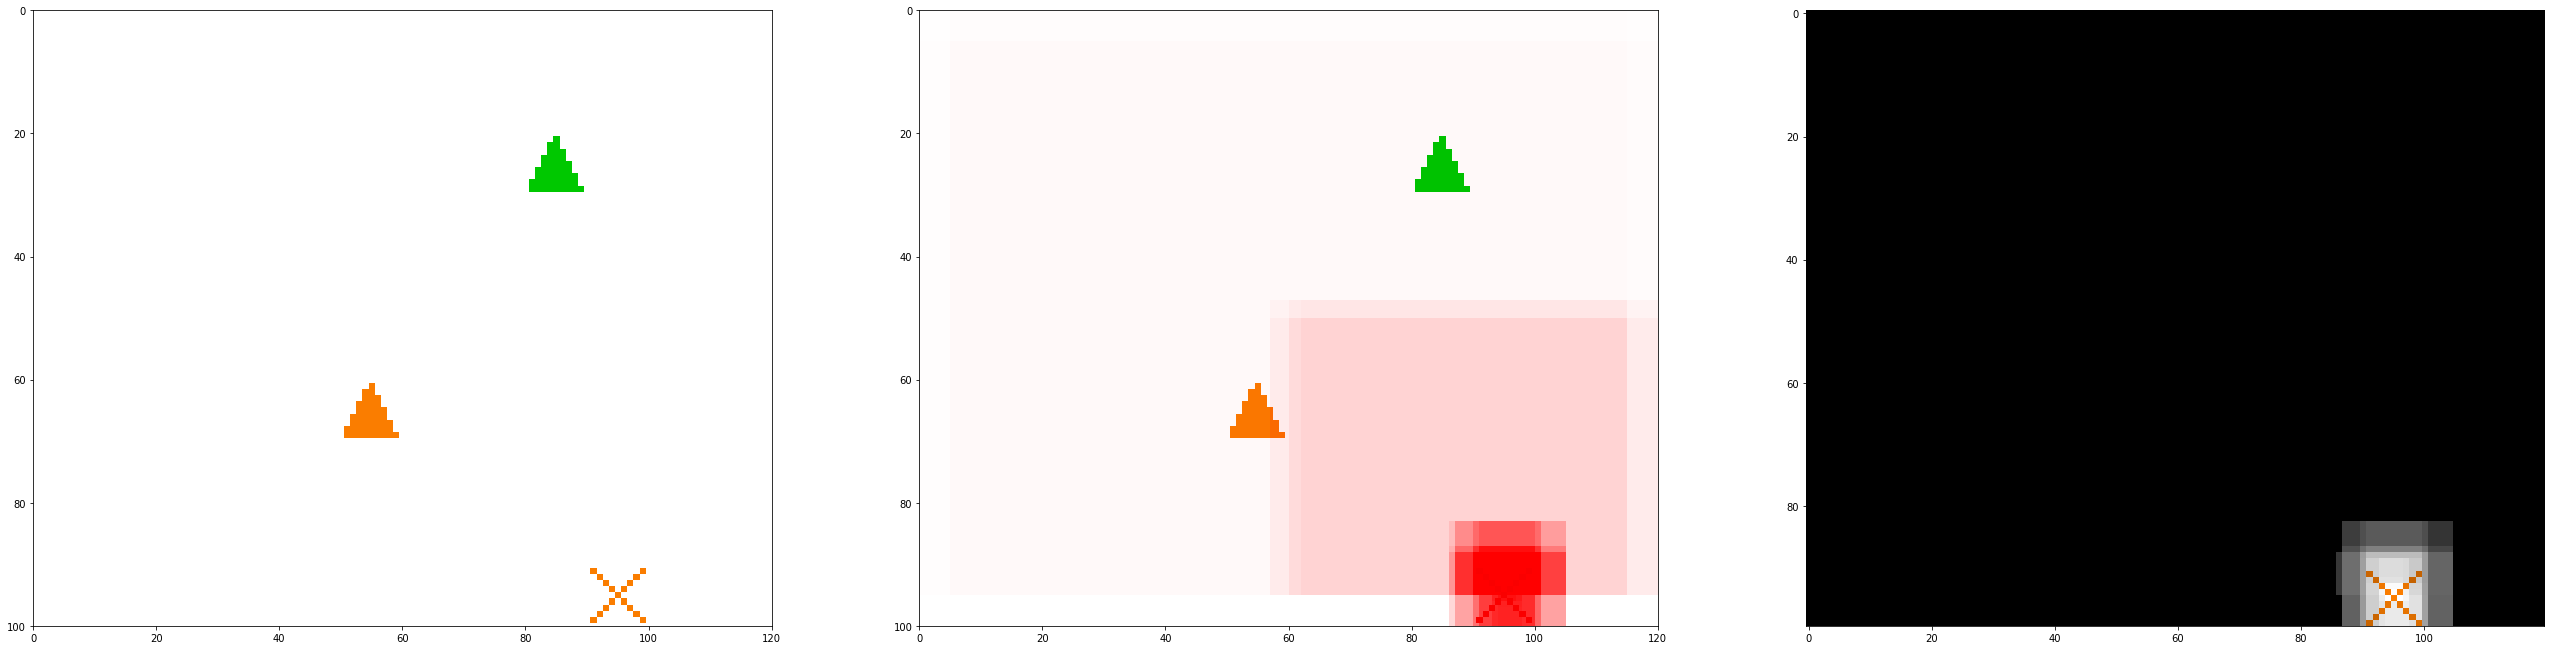

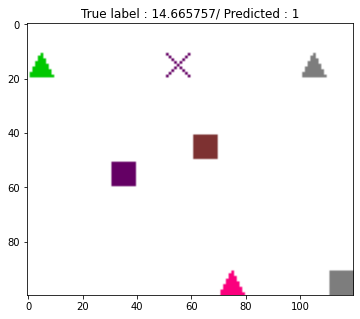

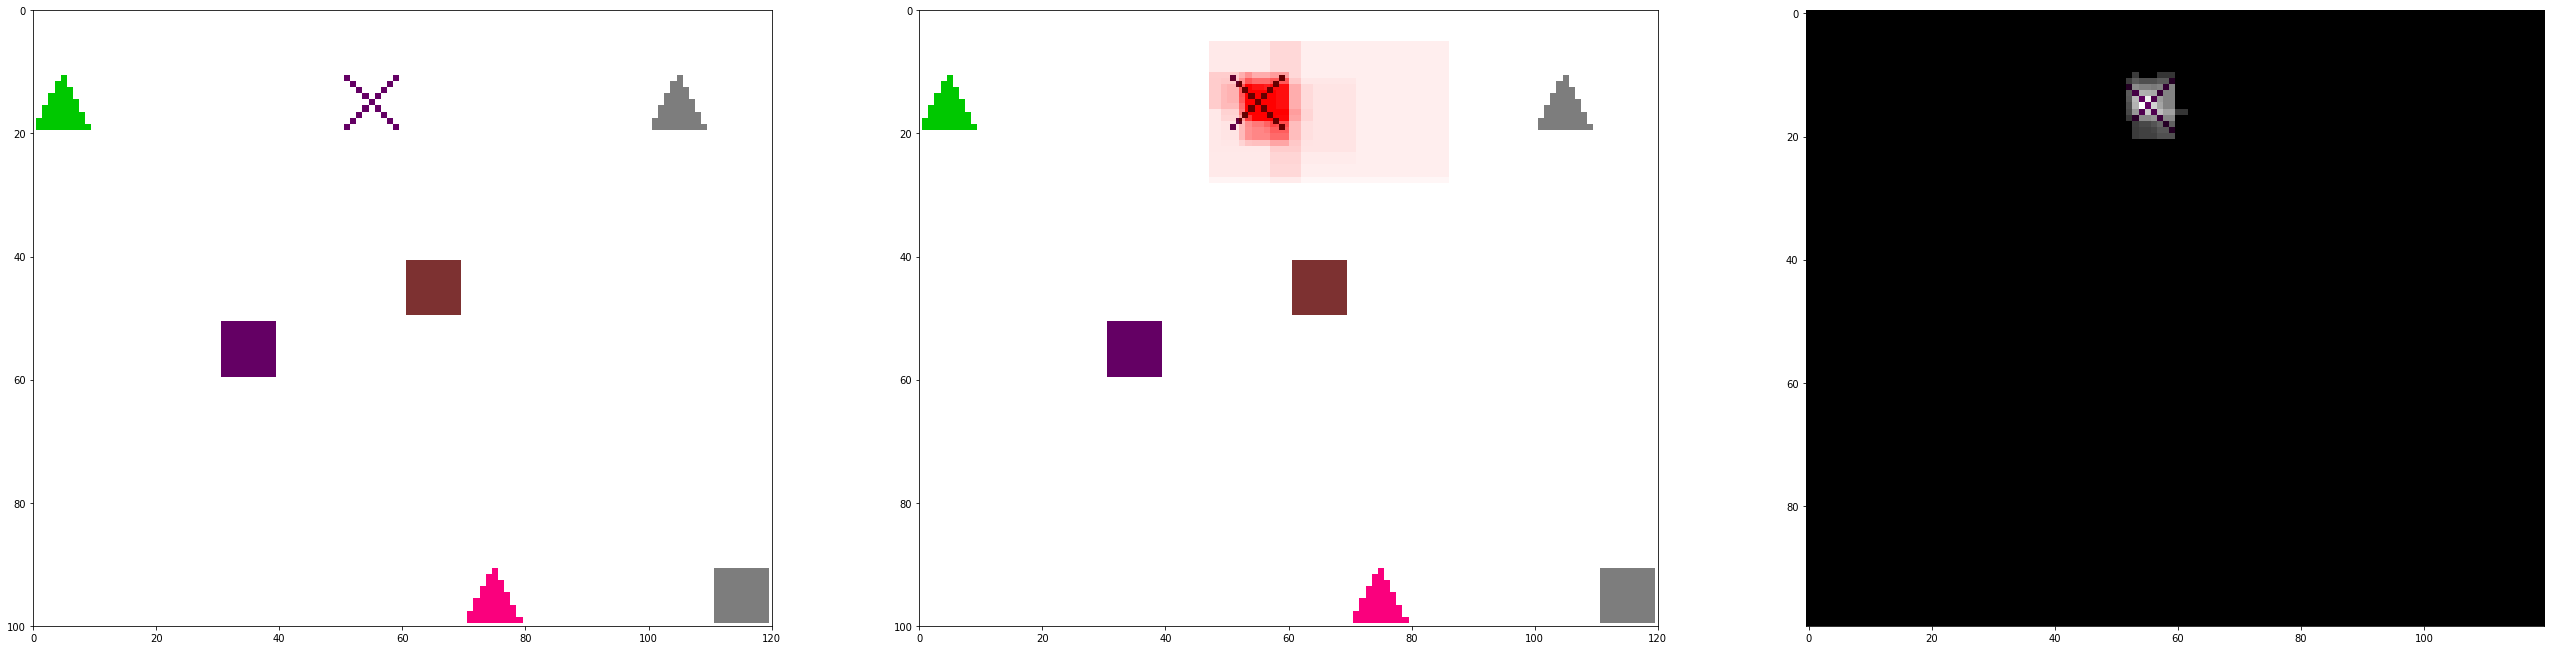

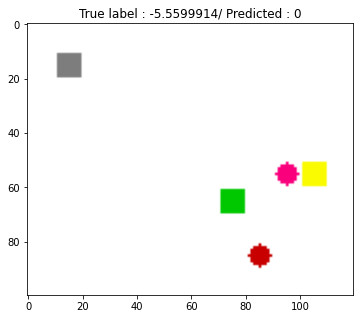

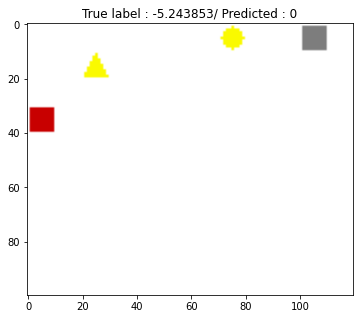

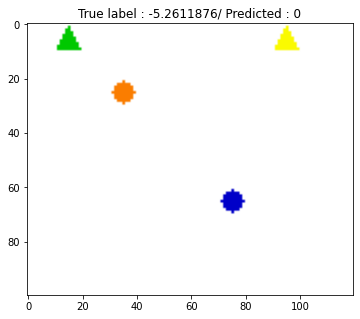

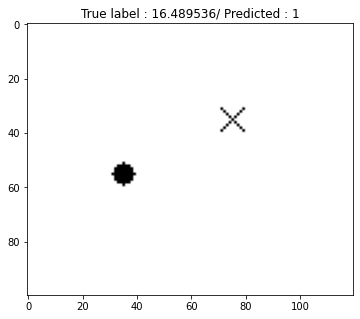

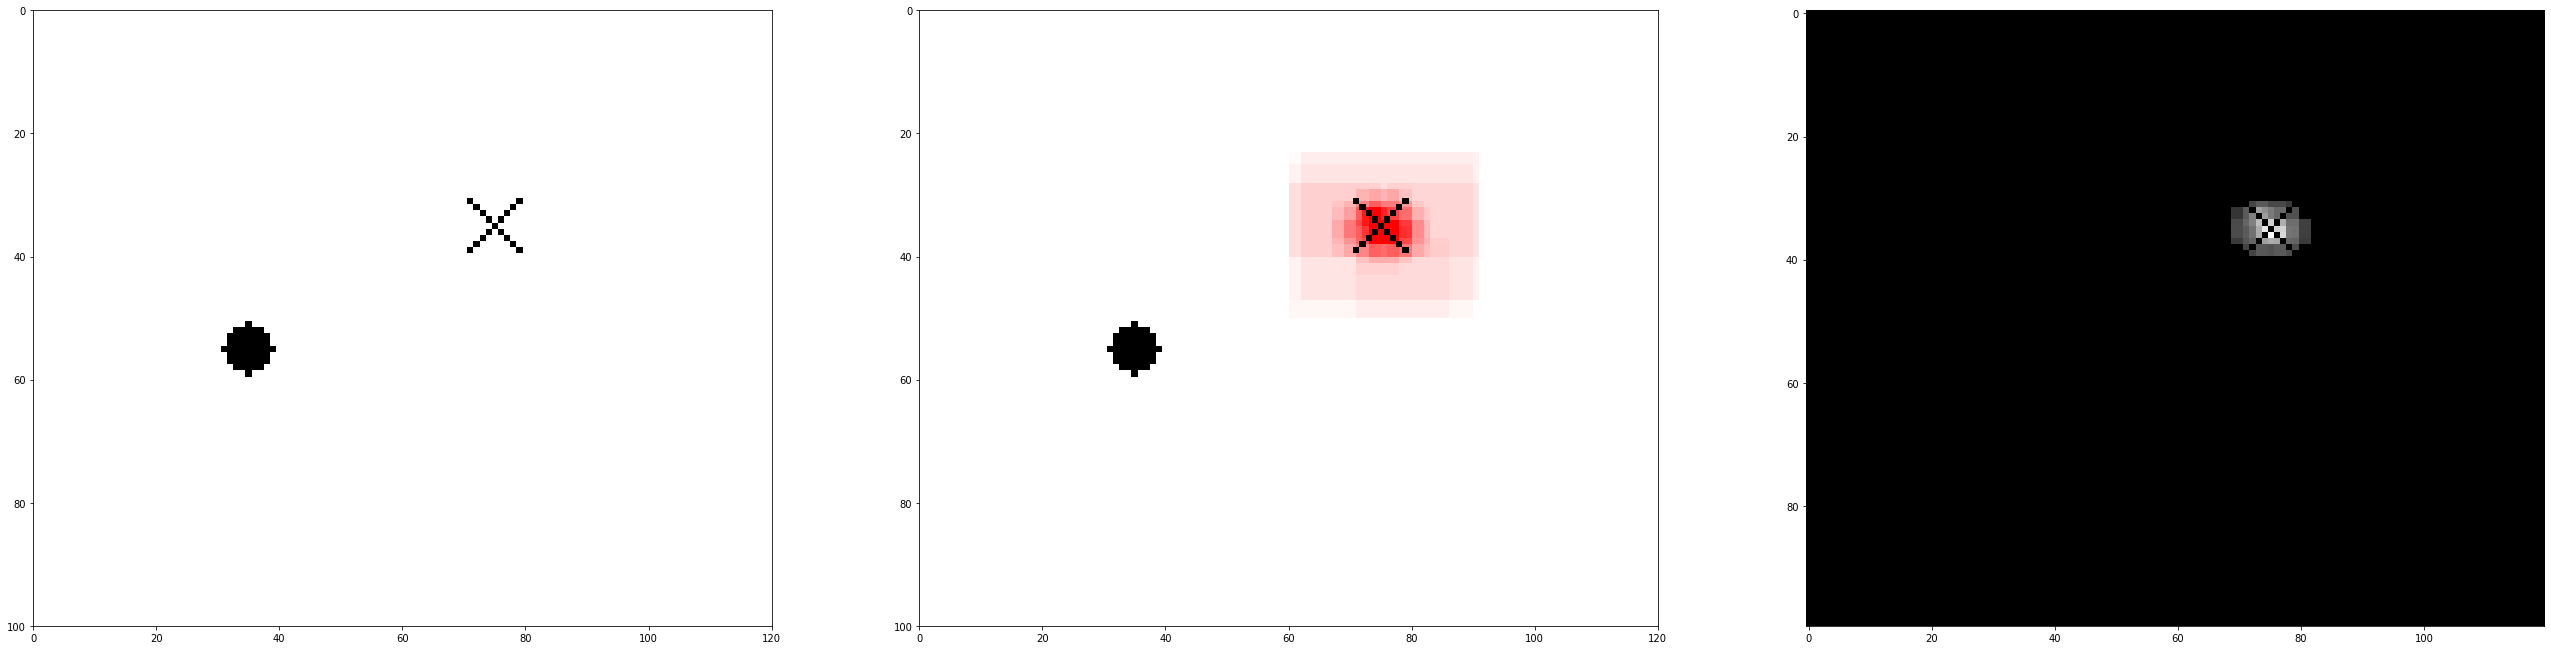

In [18]:
for i in range(20):
  image = images[i]
  label = labels[i]

  input_ = image.view(-1, 3, 100, 120) # This shape is necessary for the network 
  output = net(input_)
  _, predicted = torch.max(output.data, 1)
  a = output.data[0][1].detach().numpy()
  img = utils.input2image(image, MEAN, STD)
  utils.display_image(img, a, int(predicted))
  

  if (a > 0):
    h.saliency_map(image, label, tolerance = l, only_one_run = False)
  i += 1